In [1]:
import os
import sys

# Add the parent directory of the current script and 'src' folder to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



from src.model_unet import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your saved data
train_data = torch.load("../data/prepared_datasets/train_celeba.pt")
train_labels = torch.load("../data/prepared_datasets/train_celeba_labels.pt")
val_data = torch.load("../data/prepared_datasets/val_celeba.pt")
val_labels = torch.load("../data/prepared_datasets/val_celeba_labels.pt")
test_data = torch.load("../data/prepared_datasets/test_celeba.pt")
test_labels = torch.load("../data/prepared_datasets/test_celeba_labels.pt")

In [3]:
train_data.shape

torch.Size([162770, 3, 64, 64])

In [4]:
train_data=train_data[:80000]
train_labels=train_labels[:80000]

In [5]:
batch_size = 32

In [6]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [7]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [8]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [15]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [16]:
timesteps = 200
betas = DiffusionSchedule.linear_beta_schedule(timesteps).clone()
diffusion_params = DiffusionSchedule.compute_diffusion_parameters(betas)

In [17]:
from torchvision.utils import save_image

epochs = 50
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber")
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()

Epoch 1/50:   0%|          | 1/2500 [00:00<20:51,  2.00it/s]

Loss: 0.47678491473197937


Epoch 1/50:   4%|▍         | 101/2500 [00:15<06:01,  6.64it/s]

Loss: 0.424088716506958


Epoch 1/50:   8%|▊         | 201/2500 [00:30<05:44,  6.66it/s]

Loss: 0.42295774817466736


Epoch 1/50:  12%|█▏        | 301/2500 [00:45<05:32,  6.62it/s]

Loss: 0.4152565002441406


Epoch 1/50:  16%|█▌        | 401/2500 [01:00<05:15,  6.65it/s]

Loss: 0.3082815706729889


Epoch 1/50:  20%|██        | 501/2500 [01:15<04:55,  6.77it/s]

Loss: 0.4381757378578186


Epoch 1/50:  24%|██▍       | 601/2500 [01:30<04:51,  6.50it/s]

Loss: 0.3829226493835449


Epoch 1/50:  28%|██▊       | 701/2500 [01:45<04:15,  7.05it/s]

Loss: 0.3682158589363098


Epoch 1/50:  32%|███▏      | 801/2500 [01:59<04:12,  6.74it/s]

Loss: 0.3429437577724457


Epoch 1/50:  36%|███▌      | 901/2500 [02:14<04:03,  6.56it/s]

Loss: 0.3246905207633972


Epoch 1/50:  40%|████      | 1001/2500 [02:29<03:31,  7.08it/s]

Loss: 0.3177468180656433


Epoch 1/50:  44%|████▍     | 1101/2500 [02:44<03:30,  6.64it/s]

Loss: 0.2815079391002655


Epoch 1/50:  48%|████▊     | 1201/2500 [02:59<03:12,  6.76it/s]

Loss: 0.2647237479686737


Epoch 1/50:  52%|█████▏    | 1301/2500 [03:14<03:09,  6.31it/s]

Loss: 0.2542613744735718


Epoch 1/50:  56%|█████▌    | 1401/2500 [03:30<02:41,  6.82it/s]

Loss: 0.23229333758354187


Epoch 1/50:  60%|██████    | 1501/2500 [03:44<02:29,  6.67it/s]

Loss: 0.23855595290660858


Epoch 1/50:  64%|██████▍   | 1601/2500 [04:00<02:20,  6.41it/s]

Loss: 0.19829398393630981


Epoch 1/50:  68%|██████▊   | 1701/2500 [04:15<01:58,  6.76it/s]

Loss: 0.18977928161621094


Epoch 1/50:  72%|███████▏  | 1801/2500 [04:30<01:49,  6.38it/s]

Loss: 0.12568382918834686


Epoch 1/50:  76%|███████▌  | 1901/2500 [04:45<01:30,  6.60it/s]

Loss: 0.13252799212932587


Epoch 1/50:  80%|████████  | 2001/2500 [05:01<01:15,  6.65it/s]

Loss: 0.14102834463119507


Epoch 1/50:  84%|████████▍ | 2101/2500 [05:16<01:02,  6.39it/s]

Loss: 0.12722133100032806


Epoch 1/50:  88%|████████▊ | 2201/2500 [05:31<00:44,  6.69it/s]

Loss: 0.10264718532562256


Epoch 1/50:  92%|█████████▏| 2301/2500 [05:46<00:30,  6.43it/s]

Loss: 0.118700310587883


Epoch 1/50:  96%|█████████▌| 2401/2500 [06:01<00:16,  6.13it/s]

Loss: 0.09138500690460205



Epoch 2/50:   0%|          | 1/2500 [00:00<06:05,  6.83it/s]s]

Loss: 0.09715904295444489


Epoch 2/50:   4%|▍         | 101/2500 [00:15<05:52,  6.81it/s]

Loss: 0.11120814085006714


Epoch 2/50:   8%|▊         | 201/2500 [00:30<05:51,  6.54it/s]

Loss: 0.081122025847435


Epoch 2/50:  12%|█▏        | 301/2500 [00:45<05:31,  6.64it/s]

Loss: 0.09794332832098007


Epoch 2/50:  16%|█▌        | 401/2500 [01:01<05:22,  6.50it/s]

Loss: 0.10179762542247772


Epoch 2/50:  20%|██        | 501/2500 [01:16<05:03,  6.59it/s]

Loss: 0.07108311355113983


Epoch 2/50:  24%|██▍       | 601/2500 [01:31<04:52,  6.49it/s]

Loss: 0.06869879364967346


Epoch 2/50:  28%|██▊       | 701/2500 [01:46<04:34,  6.56it/s]

Loss: 0.06536086648702621


Epoch 2/50:  32%|███▏      | 801/2500 [02:01<04:17,  6.61it/s]

Loss: 0.0629366934299469


Epoch 2/50:  36%|███▌      | 901/2500 [02:16<04:08,  6.43it/s]

Loss: 0.05472788214683533


Epoch 2/50:  40%|████      | 1001/2500 [02:32<04:00,  6.25it/s]

Loss: 0.052150141447782516


Epoch 2/50:  44%|████▍     | 1101/2500 [02:47<03:29,  6.68it/s]

Loss: 0.04714028164744377


Epoch 2/50:  48%|████▊     | 1201/2500 [03:02<03:16,  6.62it/s]

Loss: 0.05630192160606384


Epoch 2/50:  52%|█████▏    | 1301/2500 [03:17<02:50,  7.01it/s]

Loss: 0.05434609577059746


Epoch 2/50:  56%|█████▌    | 1401/2500 [03:33<02:49,  6.49it/s]

Loss: 0.05966227501630783


Epoch 2/50:  60%|██████    | 1501/2500 [03:48<02:38,  6.29it/s]

Loss: 0.037197161465883255


Epoch 2/50:  64%|██████▍   | 1601/2500 [04:03<02:15,  6.66it/s]

Loss: 0.045222681015729904


Epoch 2/50:  68%|██████▊   | 1701/2500 [04:19<01:56,  6.85it/s]

Loss: 0.037069641053676605


Epoch 2/50:  72%|███████▏  | 1801/2500 [04:34<01:47,  6.47it/s]

Loss: 0.049040257930755615


Epoch 2/50:  76%|███████▌  | 1901/2500 [04:49<01:33,  6.42it/s]

Loss: 0.0443992093205452


Epoch 2/50:  80%|████████  | 2001/2500 [05:04<01:15,  6.65it/s]

Loss: 0.04301588237285614


Epoch 2/50:  84%|████████▍ | 2101/2500 [05:19<01:00,  6.64it/s]

Loss: 0.04175952076911926


Epoch 2/50:  88%|████████▊ | 2201/2500 [05:34<00:43,  6.91it/s]

Loss: 0.045095622539520264


Epoch 2/50:  92%|█████████▏| 2301/2500 [05:49<00:29,  6.65it/s]

Loss: 0.05769721791148186


Epoch 2/50:  96%|█████████▌| 2401/2500 [06:04<00:16,  6.17it/s]

Loss: 0.044086672365665436



Epoch 3/50:   0%|          | 1/2500 [00:00<06:19,  6.59it/s]s]

Loss: 0.03767581284046173


Epoch 3/50:   4%|▍         | 101/2500 [00:15<05:52,  6.81it/s]

Loss: 0.03981725499033928


Epoch 3/50:   8%|▊         | 201/2500 [00:30<05:44,  6.67it/s]

Loss: 0.034451600164175034


Epoch 3/50:  12%|█▏        | 301/2500 [00:45<05:33,  6.60it/s]

Loss: 0.02430655062198639


Epoch 3/50:  16%|█▌        | 401/2500 [01:00<05:23,  6.49it/s]

Loss: 0.04337352141737938


Epoch 3/50:  20%|██        | 501/2500 [01:15<05:05,  6.54it/s]

Loss: 0.02434050291776657


Epoch 3/50:  24%|██▍       | 601/2500 [01:30<04:51,  6.52it/s]

Loss: 0.03554809093475342


Epoch 3/50:  28%|██▊       | 701/2500 [01:45<04:20,  6.91it/s]

Loss: 0.035136304795742035


Epoch 3/50:  32%|███▏      | 801/2500 [02:00<04:12,  6.73it/s]

Loss: 0.03366119787096977


Epoch 3/50:  36%|███▌      | 901/2500 [02:15<04:05,  6.52it/s]

Loss: 0.03340274840593338


Epoch 3/50:  40%|████      | 1001/2500 [02:30<03:34,  6.98it/s]

Loss: 0.02701551280915737


Epoch 3/50:  44%|████▍     | 1101/2500 [02:45<03:22,  6.90it/s]

Loss: 0.039295364171266556


Epoch 3/50:  48%|████▊     | 1201/2500 [03:00<03:14,  6.68it/s]

Loss: 0.03582305461168289


Epoch 3/50:  52%|█████▏    | 1301/2500 [03:15<02:59,  6.67it/s]

Loss: 0.025627566501498222


Epoch 3/50:  56%|█████▌    | 1401/2500 [03:30<02:52,  6.38it/s]

Loss: 0.05252178758382797


Epoch 3/50:  60%|██████    | 1501/2500 [03:45<02:33,  6.53it/s]

Loss: 0.030215328559279442


Epoch 3/50:  64%|██████▍   | 1601/2500 [04:00<02:16,  6.57it/s]

Loss: 0.02733757160604


Epoch 3/50:  68%|██████▊   | 1701/2500 [04:15<01:52,  7.11it/s]

Loss: 0.02080978825688362


Epoch 3/50:  72%|███████▏  | 1801/2500 [04:30<01:44,  6.68it/s]

Loss: 0.040938396006822586


Epoch 3/50:  76%|███████▌  | 1901/2500 [04:45<01:34,  6.35it/s]

Loss: 0.033808186650276184


Epoch 3/50:  80%|████████  | 2001/2500 [05:01<01:14,  6.70it/s]

Loss: 0.02665979228913784


Epoch 3/50:  84%|████████▍ | 2101/2500 [05:16<01:01,  6.47it/s]

Loss: 0.028352603316307068


Epoch 3/50:  88%|████████▊ | 2201/2500 [05:31<00:44,  6.68it/s]

Loss: 0.03936200588941574


Epoch 3/50:  92%|█████████▏| 2301/2500 [05:45<00:28,  6.88it/s]

Loss: 0.03772750496864319


Epoch 3/50:  96%|█████████▌| 2401/2500 [06:00<00:14,  7.05it/s]

Loss: 0.02987806871533394



Epoch 4/50:   0%|          | 1/2500 [00:00<06:21,  6.54it/s]s]

Loss: 0.02451915107667446


Epoch 4/50:   4%|▍         | 101/2500 [00:15<06:03,  6.61it/s]

Loss: 0.03380881994962692


Epoch 4/50:   8%|▊         | 201/2500 [00:30<05:39,  6.78it/s]

Loss: 0.026634102687239647


Epoch 4/50:  12%|█▏        | 301/2500 [00:45<05:17,  6.92it/s]

Loss: 0.02844422124326229


Epoch 4/50:  16%|█▌        | 401/2500 [01:00<05:15,  6.65it/s]

Loss: 0.041364267468452454


Epoch 4/50:  20%|██        | 501/2500 [01:15<05:06,  6.52it/s]

Loss: 0.0404449924826622


Epoch 4/50:  24%|██▍       | 601/2500 [01:30<04:50,  6.54it/s]

Loss: 0.03815114125609398


Epoch 4/50:  28%|██▊       | 701/2500 [01:45<04:29,  6.68it/s]

Loss: 0.031973838806152344


Epoch 4/50:  32%|███▏      | 801/2500 [02:00<04:09,  6.80it/s]

Loss: 0.025309234857559204


Epoch 4/50:  36%|███▌      | 901/2500 [02:15<03:51,  6.92it/s]

Loss: 0.025509566068649292


Epoch 4/50:  40%|████      | 1001/2500 [02:30<03:37,  6.89it/s]

Loss: 0.02281658723950386


Epoch 4/50:  44%|████▍     | 1101/2500 [02:45<03:40,  6.34it/s]

Loss: 0.027324911206960678


Epoch 4/50:  48%|████▊     | 1201/2500 [03:00<03:07,  6.92it/s]

Loss: 0.03709995001554489


Epoch 4/50:  52%|█████▏    | 1301/2500 [03:15<02:56,  6.81it/s]

Loss: 0.01640843227505684


Epoch 4/50:  56%|█████▌    | 1401/2500 [03:30<02:45,  6.63it/s]

Loss: 0.023028982803225517


Epoch 4/50:  60%|██████    | 1501/2500 [03:45<02:31,  6.61it/s]

Loss: 0.02655237726867199


Epoch 4/50:  64%|██████▍   | 1601/2500 [03:59<02:26,  6.12it/s]

Loss: 0.035829778760671616


Epoch 4/50:  68%|██████▊   | 1701/2500 [04:14<01:54,  6.96it/s]

Loss: 0.028382686898112297


Epoch 4/50:  72%|███████▏  | 1801/2500 [04:29<01:42,  6.83it/s]

Loss: 0.026375871151685715


Epoch 4/50:  76%|███████▌  | 1901/2500 [04:44<01:28,  6.74it/s]

Loss: 0.01650887355208397


Epoch 4/50:  80%|████████  | 2001/2500 [04:59<01:13,  6.83it/s]

Loss: 0.017413968220353127


Epoch 4/50:  84%|████████▍ | 2101/2500 [05:14<00:59,  6.65it/s]

Loss: 0.020802397280931473


Epoch 4/50:  88%|████████▊ | 2201/2500 [05:28<00:44,  6.70it/s]

Loss: 0.03909967839717865


Epoch 4/50:  92%|█████████▏| 2301/2500 [05:43<00:30,  6.60it/s]

Loss: 0.028840728104114532


Epoch 4/50:  96%|█████████▌| 2401/2500 [05:58<00:15,  6.56it/s]

Loss: 0.029966119676828384



Epoch 5/50:   0%|          | 1/2500 [00:00<06:12,  6.71it/s]s]

Loss: 0.023177027702331543


Epoch 5/50:   4%|▍         | 101/2500 [00:14<05:59,  6.66it/s]

Loss: 0.027980457991361618


Epoch 5/50:   8%|▊         | 201/2500 [00:29<05:31,  6.94it/s]

Loss: 0.026978900656104088


Epoch 5/50:  12%|█▏        | 301/2500 [00:44<05:36,  6.54it/s]

Loss: 0.03250180929899216


Epoch 5/50:  16%|█▌        | 401/2500 [00:59<05:03,  6.92it/s]

Loss: 0.021871671080589294


Epoch 5/50:  20%|██        | 501/2500 [01:14<04:48,  6.94it/s]

Loss: 0.021998746320605278


Epoch 5/50:  24%|██▍       | 601/2500 [01:28<04:43,  6.71it/s]

Loss: 0.01596238650381565


Epoch 5/50:  28%|██▊       | 701/2500 [01:43<04:29,  6.67it/s]

Loss: 0.020029373466968536


Epoch 5/50:  32%|███▏      | 801/2500 [01:58<04:17,  6.61it/s]

Loss: 0.030231846496462822


Epoch 5/50:  36%|███▌      | 901/2500 [02:13<04:12,  6.34it/s]

Loss: 0.02348521165549755


Epoch 5/50:  40%|████      | 1001/2500 [02:28<03:39,  6.83it/s]

Loss: 0.019409341737627983


Epoch 5/50:  44%|████▍     | 1101/2500 [02:43<03:19,  7.02it/s]

Loss: 0.027188388630747795


Epoch 5/50:  48%|████▊     | 1201/2500 [02:58<03:24,  6.36it/s]

Loss: 0.0316191129386425


Epoch 5/50:  52%|█████▏    | 1301/2500 [03:13<03:03,  6.55it/s]

Loss: 0.017566397786140442


Epoch 5/50:  56%|█████▌    | 1401/2500 [03:28<02:34,  7.11it/s]

Loss: 0.023563077673316002


Epoch 5/50:  60%|██████    | 1501/2500 [03:43<02:29,  6.68it/s]

Loss: 0.021941600367426872


Epoch 5/50:  64%|██████▍   | 1601/2500 [03:58<02:10,  6.89it/s]

Loss: 0.01734602078795433


Epoch 5/50:  68%|██████▊   | 1701/2500 [04:13<01:54,  6.98it/s]

Loss: 0.01878293603658676


Epoch 5/50:  72%|███████▏  | 1801/2500 [04:28<01:49,  6.39it/s]

Loss: 0.02624659799039364


Epoch 5/50:  76%|███████▌  | 1901/2500 [04:43<01:29,  6.69it/s]

Loss: 0.025009743869304657


Epoch 5/50:  80%|████████  | 2001/2500 [04:58<01:10,  7.06it/s]

Loss: 0.017867570742964745


Epoch 5/50:  84%|████████▍ | 2101/2500 [05:13<01:02,  6.41it/s]

Loss: 0.03589388728141785


Epoch 5/50:  88%|████████▊ | 2201/2500 [05:28<00:43,  6.84it/s]

Loss: 0.01855558715760708


Epoch 5/50:  92%|█████████▏| 2301/2500 [05:43<00:30,  6.53it/s]

Loss: 0.029564153403043747


Epoch 5/50:  96%|█████████▌| 2401/2500 [05:58<00:14,  6.89it/s]

Loss: 0.024688145145773888



Epoch 6/50:   0%|          | 1/2500 [00:00<06:39,  6.26it/s]s]

Loss: 0.0193573497235775


Epoch 6/50:   4%|▍         | 101/2500 [00:14<05:34,  7.17it/s]

Loss: 0.028101865202188492


Epoch 6/50:   8%|▊         | 201/2500 [00:29<05:52,  6.52it/s]

Loss: 0.022267870604991913


Epoch 6/50:  12%|█▏        | 301/2500 [00:44<05:43,  6.41it/s]

Loss: 0.02805769443511963


Epoch 6/50:  16%|█▌        | 401/2500 [00:59<05:02,  6.93it/s]

Loss: 0.0252071525901556


Epoch 6/50:  20%|██        | 501/2500 [01:14<04:53,  6.82it/s]

Loss: 0.0211339108645916


Epoch 6/50:  24%|██▍       | 601/2500 [01:28<04:30,  7.01it/s]

Loss: 0.02085529826581478


Epoch 6/50:  28%|██▊       | 701/2500 [01:43<04:32,  6.61it/s]

Loss: 0.022081254050135612


Epoch 6/50:  32%|███▏      | 801/2500 [01:58<04:22,  6.47it/s]

Loss: 0.02364801988005638


Epoch 6/50:  36%|███▌      | 901/2500 [02:13<03:56,  6.77it/s]

Loss: 0.018150318413972855


Epoch 6/50:  40%|████      | 1001/2500 [02:28<03:36,  6.91it/s]

Loss: 0.01806947961449623


Epoch 6/50:  44%|████▍     | 1101/2500 [02:43<03:23,  6.87it/s]

Loss: 0.020771436393260956


Epoch 6/50:  48%|████▊     | 1201/2500 [02:58<03:11,  6.77it/s]

Loss: 0.016754157841205597


Epoch 6/50:  52%|█████▏    | 1301/2500 [03:13<03:05,  6.46it/s]

Loss: 0.022877752780914307


Epoch 6/50:  56%|█████▌    | 1401/2500 [03:28<02:36,  7.00it/s]

Loss: 0.021279003471136093


Epoch 6/50:  60%|██████    | 1501/2500 [03:42<02:28,  6.74it/s]

Loss: 0.02755296789109707


Epoch 6/50:  64%|██████▍   | 1601/2500 [03:57<02:05,  7.14it/s]

Loss: 0.02478419989347458


Epoch 6/50:  68%|██████▊   | 1701/2500 [04:12<01:55,  6.90it/s]

Loss: 0.017833571881055832


Epoch 6/50:  72%|███████▏  | 1801/2500 [04:26<01:44,  6.66it/s]

Loss: 0.018353013321757317


Epoch 6/50:  76%|███████▌  | 1901/2500 [04:41<01:24,  7.05it/s]

Loss: 0.022867798805236816


Epoch 6/50:  80%|████████  | 2001/2500 [04:56<01:17,  6.44it/s]

Loss: 0.02208906225860119


Epoch 6/50:  84%|████████▍ | 2101/2500 [05:11<00:57,  6.88it/s]

Loss: 0.03219812735915184


Epoch 6/50:  88%|████████▊ | 2201/2500 [05:25<00:42,  6.95it/s]

Loss: 0.02429533749818802


Epoch 6/50:  92%|█████████▏| 2301/2500 [05:40<00:30,  6.63it/s]

Loss: 0.027977794408798218


Epoch 6/50:  96%|█████████▌| 2401/2500 [05:55<00:14,  6.96it/s]

Loss: 0.02495969459414482



Epoch 7/50:   0%|          | 1/2500 [00:00<06:04,  6.85it/s]s]

Loss: 0.017680689692497253


Epoch 7/50:   4%|▍         | 101/2500 [00:14<05:45,  6.94it/s]

Loss: 0.0195807833224535


Epoch 7/50:   8%|▊         | 201/2500 [00:29<05:36,  6.83it/s]

Loss: 0.018555648624897003


Epoch 7/50:  12%|█▏        | 301/2500 [00:43<05:14,  6.99it/s]

Loss: 0.021023698151111603


Epoch 7/50:  16%|█▌        | 401/2500 [00:58<05:00,  6.98it/s]

Loss: 0.020388726145029068


Epoch 7/50:  20%|██        | 501/2500 [01:13<04:58,  6.70it/s]

Loss: 0.027985816821455956


Epoch 7/50:  24%|██▍       | 601/2500 [01:27<04:42,  6.73it/s]

Loss: 0.023631639778614044


Epoch 7/50:  28%|██▊       | 701/2500 [01:42<04:34,  6.56it/s]

Loss: 0.02183103933930397


Epoch 7/50:  32%|███▏      | 801/2500 [01:57<04:09,  6.81it/s]

Loss: 0.02299650013446808


Epoch 7/50:  36%|███▌      | 901/2500 [02:12<03:54,  6.83it/s]

Loss: 0.018315955996513367


Epoch 7/50:  40%|████      | 1001/2500 [02:27<03:46,  6.62it/s]

Loss: 0.0221159216016531


Epoch 7/50:  44%|████▍     | 1101/2500 [02:42<03:34,  6.52it/s]

Loss: 0.018641676753759384


Epoch 7/50:  48%|████▊     | 1201/2500 [02:56<03:20,  6.49it/s]

Loss: 0.026079796254634857


Epoch 7/50:  52%|█████▏    | 1301/2500 [03:11<02:55,  6.83it/s]

Loss: 0.0112113356590271


Epoch 7/50:  56%|█████▌    | 1401/2500 [03:26<02:41,  6.79it/s]

Loss: 0.03230496868491173


Epoch 7/50:  60%|██████    | 1501/2500 [03:40<02:31,  6.60it/s]

Loss: 0.02596733532845974


Epoch 7/50:  64%|██████▍   | 1601/2500 [03:56<02:18,  6.51it/s]

Loss: 0.02084076963365078


Epoch 7/50:  68%|██████▊   | 1701/2500 [04:10<02:06,  6.32it/s]

Loss: 0.019115818664431572


Epoch 7/50:  72%|███████▏  | 1801/2500 [04:25<01:46,  6.59it/s]

Loss: 0.023601580411195755


Epoch 7/50:  76%|███████▌  | 1901/2500 [04:41<01:30,  6.64it/s]

Loss: 0.028971707448363304


Epoch 7/50:  80%|████████  | 2001/2500 [04:55<01:17,  6.42it/s]

Loss: 0.017988715320825577


Epoch 7/50:  84%|████████▍ | 2101/2500 [05:10<01:01,  6.51it/s]

Loss: 0.02619972452521324


Epoch 7/50:  88%|████████▊ | 2201/2500 [05:25<00:46,  6.36it/s]

Loss: 0.021080655977129936


Epoch 7/50:  92%|█████████▏| 2301/2500 [05:40<00:28,  6.91it/s]

Loss: 0.013542970642447472


Epoch 7/50:  96%|█████████▌| 2401/2500 [05:56<00:15,  6.49it/s]

Loss: 0.026375815272331238



Epoch 8/50:   0%|          | 1/2500 [00:00<06:05,  6.83it/s]s]

Loss: 0.023273898288607597


Epoch 8/50:   4%|▍         | 101/2500 [00:14<05:40,  7.05it/s]

Loss: 0.028056679293513298


Epoch 8/50:   8%|▊         | 201/2500 [00:29<06:06,  6.28it/s]

Loss: 0.014251369051635265


Epoch 8/50:  12%|█▏        | 301/2500 [00:44<05:12,  7.03it/s]

Loss: 0.029858071357011795


Epoch 8/50:  16%|█▌        | 401/2500 [00:59<04:57,  7.05it/s]

Loss: 0.01965351402759552


Epoch 8/50:  20%|██        | 501/2500 [01:13<04:48,  6.94it/s]

Loss: 0.018854772672057152


Epoch 8/50:  24%|██▍       | 601/2500 [01:28<04:30,  7.01it/s]

Loss: 0.025656698271632195


Epoch 8/50:  28%|██▊       | 701/2500 [01:42<04:22,  6.86it/s]

Loss: 0.015376262366771698


Epoch 8/50:  32%|███▏      | 801/2500 [01:57<04:10,  6.78it/s]

Loss: 0.012630867771804333


Epoch 8/50:  36%|███▌      | 901/2500 [02:12<03:55,  6.78it/s]

Loss: 0.02745978906750679


Epoch 8/50:  40%|████      | 1001/2500 [02:27<03:26,  7.27it/s]

Loss: 0.024689551442861557


Epoch 8/50:  44%|████▍     | 1101/2500 [02:42<03:42,  6.28it/s]

Loss: 0.013838445767760277


Epoch 8/50:  48%|████▊     | 1201/2500 [02:57<03:16,  6.62it/s]

Loss: 0.022179296240210533


Epoch 8/50:  52%|█████▏    | 1301/2500 [03:12<03:06,  6.43it/s]

Loss: 0.021239440888166428


Epoch 8/50:  56%|█████▌    | 1401/2500 [03:27<02:40,  6.86it/s]

Loss: 0.015155027620494366


Epoch 8/50:  60%|██████    | 1501/2500 [03:43<02:26,  6.80it/s]

Loss: 0.022022685036063194


Epoch 8/50:  64%|██████▍   | 1601/2500 [03:58<02:11,  6.84it/s]

Loss: 0.0194797795265913


Epoch 8/50:  68%|██████▊   | 1701/2500 [04:13<02:02,  6.53it/s]

Loss: 0.022356722503900528


Epoch 8/50:  72%|███████▏  | 1801/2500 [04:28<01:50,  6.34it/s]

Loss: 0.029329797253012657


Epoch 8/50:  76%|███████▌  | 1901/2500 [04:43<01:27,  6.83it/s]

Loss: 0.02308095619082451


Epoch 8/50:  80%|████████  | 2001/2500 [04:59<01:17,  6.43it/s]

Loss: 0.019587170332670212


Epoch 8/50:  84%|████████▍ | 2101/2500 [05:13<01:00,  6.60it/s]

Loss: 0.02111285924911499


Epoch 8/50:  88%|████████▊ | 2201/2500 [05:28<00:42,  7.01it/s]

Loss: 0.021523987874388695


Epoch 8/50:  92%|█████████▏| 2301/2500 [05:43<00:32,  6.21it/s]

Loss: 0.018425103276968002


Epoch 8/50:  96%|█████████▌| 2401/2500 [05:58<00:14,  6.68it/s]

Loss: 0.02339205890893936



Epoch 9/50:   0%|          | 1/2500 [00:00<06:13,  6.69it/s]s]

Loss: 0.017945297062397003


Epoch 9/50:   4%|▍         | 101/2500 [00:15<06:08,  6.50it/s]

Loss: 0.025102730840444565


Epoch 9/50:   8%|▊         | 201/2500 [00:30<05:51,  6.54it/s]

Loss: 0.018313180655241013


Epoch 9/50:  12%|█▏        | 301/2500 [00:46<05:24,  6.78it/s]

Loss: 0.01677914708852768


Epoch 9/50:  16%|█▌        | 401/2500 [01:01<05:21,  6.53it/s]

Loss: 0.021635260432958603


Epoch 9/50:  20%|██        | 501/2500 [01:15<04:52,  6.84it/s]

Loss: 0.021324237808585167


Epoch 9/50:  24%|██▍       | 601/2500 [01:30<04:37,  6.84it/s]

Loss: 0.01641245000064373


Epoch 9/50:  28%|██▊       | 701/2500 [01:45<04:52,  6.15it/s]

Loss: 0.019385425373911858


Epoch 9/50:  32%|███▏      | 801/2500 [02:00<04:25,  6.39it/s]

Loss: 0.029712170362472534


Epoch 9/50:  36%|███▌      | 901/2500 [02:15<04:07,  6.47it/s]

Loss: 0.014899682253599167


Epoch 9/50:  40%|████      | 1001/2500 [02:30<03:36,  6.93it/s]

Loss: 0.02798409014940262


Epoch 9/50:  44%|████▍     | 1101/2500 [02:44<03:21,  6.93it/s]

Loss: 0.02280363440513611


Epoch 9/50:  48%|████▊     | 1201/2500 [02:59<03:15,  6.65it/s]

Loss: 0.020301910117268562


Epoch 9/50:  52%|█████▏    | 1301/2500 [03:14<02:51,  7.01it/s]

Loss: 0.01326663326472044


Epoch 9/50:  56%|█████▌    | 1401/2500 [03:29<02:42,  6.76it/s]

Loss: 0.015845440328121185


Epoch 9/50:  60%|██████    | 1501/2500 [03:43<02:23,  6.97it/s]

Loss: 0.01829972304403782


Epoch 9/50:  64%|██████▍   | 1601/2500 [03:58<02:10,  6.91it/s]

Loss: 0.014962616376578808


Epoch 9/50:  68%|██████▊   | 1701/2500 [04:12<01:58,  6.73it/s]

Loss: 0.023074155673384666


Epoch 9/50:  72%|███████▏  | 1801/2500 [04:27<01:39,  6.99it/s]

Loss: 0.020084872841835022


Epoch 9/50:  76%|███████▌  | 1901/2500 [04:42<01:30,  6.65it/s]

Loss: 0.017112422734498978


Epoch 9/50:  80%|████████  | 2001/2500 [04:56<01:12,  6.87it/s]

Loss: 0.03623884916305542


Epoch 9/50:  84%|████████▍ | 2101/2500 [05:11<01:02,  6.43it/s]

Loss: 0.017514633014798164


Epoch 9/50:  88%|████████▊ | 2201/2500 [05:26<00:44,  6.74it/s]

Loss: 0.01228010468184948


Epoch 9/50:  92%|█████████▏| 2301/2500 [05:41<00:27,  7.16it/s]

Loss: 0.012541212141513824


Epoch 9/50:  96%|█████████▌| 2401/2500 [05:55<00:15,  6.47it/s]

Loss: 0.020197633653879166



Epoch 10/50:   0%|          | 1/2500 [00:00<06:39,  6.26it/s]]

Loss: 0.015436343848705292


Epoch 10/50:   4%|▍         | 101/2500 [00:14<05:48,  6.89it/s]

Loss: 0.024999914690852165


Epoch 10/50:   8%|▊         | 201/2500 [00:29<05:37,  6.81it/s]

Loss: 0.02731475979089737


Epoch 10/50:  12%|█▏        | 301/2500 [00:44<05:42,  6.41it/s]

Loss: 0.023547759279608727


Epoch 10/50:  16%|█▌        | 401/2500 [00:58<05:10,  6.75it/s]

Loss: 0.02295495569705963


Epoch 10/50:  20%|██        | 501/2500 [01:13<05:09,  6.46it/s]

Loss: 0.01620987430214882


Epoch 10/50:  24%|██▍       | 601/2500 [01:28<04:29,  7.06it/s]

Loss: 0.027297882363200188


Epoch 10/50:  28%|██▊       | 701/2500 [01:42<04:16,  7.00it/s]

Loss: 0.020714420825242996


Epoch 10/50:  32%|███▏      | 801/2500 [01:57<04:09,  6.80it/s]

Loss: 0.01536870189011097


Epoch 10/50:  36%|███▌      | 901/2500 [02:12<03:59,  6.68it/s]

Loss: 0.020700868219137192


Epoch 10/50:  40%|████      | 1001/2500 [02:27<03:39,  6.84it/s]

Loss: 0.01604694500565529


Epoch 10/50:  44%|████▍     | 1101/2500 [02:41<03:29,  6.69it/s]

Loss: 0.023144079372286797


Epoch 10/50:  48%|████▊     | 1201/2500 [02:56<03:10,  6.81it/s]

Loss: 0.015963833779096603


Epoch 10/50:  52%|█████▏    | 1301/2500 [03:10<02:54,  6.88it/s]

Loss: 0.015965593978762627


Epoch 10/50:  56%|█████▌    | 1401/2500 [03:25<02:37,  6.99it/s]

Loss: 0.02199549973011017


Epoch 10/50:  60%|██████    | 1501/2500 [03:40<02:23,  6.96it/s]

Loss: 0.01870054006576538


Epoch 10/50:  64%|██████▍   | 1601/2500 [03:54<02:06,  7.12it/s]

Loss: 0.024953067302703857


Epoch 10/50:  68%|██████▊   | 1701/2500 [04:09<01:52,  7.10it/s]

Loss: 0.014867130666971207


Epoch 10/50:  72%|███████▏  | 1801/2500 [04:23<01:41,  6.89it/s]

Loss: 0.014851639978587627


Epoch 10/50:  76%|███████▌  | 1901/2500 [04:38<01:27,  6.86it/s]

Loss: 0.014319760724902153


Epoch 10/50:  80%|████████  | 2001/2500 [04:53<01:17,  6.47it/s]

Loss: 0.02207523211836815


Epoch 10/50:  84%|████████▍ | 2101/2500 [05:08<00:59,  6.68it/s]

Loss: 0.03191719949245453


Epoch 10/50:  88%|████████▊ | 2201/2500 [05:23<00:45,  6.63it/s]

Loss: 0.037477876991033554


Epoch 10/50:  92%|█████████▏| 2301/2500 [05:38<00:29,  6.67it/s]

Loss: 0.0348682664334774


Epoch 10/50:  96%|█████████▌| 2401/2500 [05:53<00:14,  6.69it/s]

Loss: 0.013072611764073372



Epoch 11/50:   0%|          | 1/2500 [00:00<06:07,  6.80it/s]s]

Loss: 0.01788271777331829


Epoch 11/50:   4%|▍         | 101/2500 [00:15<06:02,  6.62it/s]

Loss: 0.024226102977991104


Epoch 11/50:   8%|▊         | 201/2500 [00:30<05:31,  6.93it/s]

Loss: 0.014808690175414085


Epoch 11/50:  12%|█▏        | 301/2500 [00:45<05:35,  6.55it/s]

Loss: 0.018098976463079453


Epoch 11/50:  16%|█▌        | 401/2500 [01:00<05:19,  6.56it/s]

Loss: 0.013055703602731228


Epoch 11/50:  20%|██        | 501/2500 [01:15<04:52,  6.84it/s]

Loss: 0.01698438636958599


Epoch 11/50:  24%|██▍       | 601/2500 [01:30<04:49,  6.56it/s]

Loss: 0.025232452899217606


Epoch 11/50:  28%|██▊       | 701/2500 [01:45<04:23,  6.82it/s]

Loss: 0.01940161921083927


Epoch 11/50:  32%|███▏      | 801/2500 [02:00<04:05,  6.92it/s]

Loss: 0.021416086703538895


Epoch 11/50:  36%|███▌      | 901/2500 [02:15<04:06,  6.48it/s]

Loss: 0.023325052112340927


Epoch 11/50:  40%|████      | 1001/2500 [02:30<03:50,  6.49it/s]

Loss: 0.0222511924803257


Epoch 11/50:  44%|████▍     | 1101/2500 [02:45<03:26,  6.77it/s]

Loss: 0.016300883144140244


Epoch 11/50:  48%|████▊     | 1201/2500 [03:00<03:12,  6.76it/s]

Loss: 0.020323000848293304


Epoch 11/50:  52%|█████▏    | 1301/2500 [03:16<03:10,  6.31it/s]

Loss: 0.0248978640884161


Epoch 11/50:  56%|█████▌    | 1401/2500 [03:31<02:47,  6.57it/s]

Loss: 0.01828758977353573


Epoch 11/50:  60%|██████    | 1501/2500 [03:46<02:31,  6.60it/s]

Loss: 0.027060743421316147


Epoch 11/50:  64%|██████▍   | 1601/2500 [04:02<02:12,  6.77it/s]

Loss: 0.015097039751708508


Epoch 11/50:  68%|██████▊   | 1701/2500 [04:17<02:07,  6.28it/s]

Loss: 0.019613390788435936


Epoch 11/50:  72%|███████▏  | 1801/2500 [04:32<01:49,  6.37it/s]

Loss: 0.024530258029699326


Epoch 11/50:  76%|███████▌  | 1901/2500 [04:47<01:33,  6.43it/s]

Loss: 0.020615320652723312


Epoch 11/50:  80%|████████  | 2001/2500 [05:03<01:20,  6.18it/s]

Loss: 0.014935348182916641


Epoch 11/50:  84%|████████▍ | 2101/2500 [05:18<01:03,  6.30it/s]

Loss: 0.01916438154876232


Epoch 11/50:  88%|████████▊ | 2201/2500 [05:34<00:46,  6.38it/s]

Loss: 0.01745196059346199


Epoch 11/50:  92%|█████████▏| 2301/2500 [05:50<00:31,  6.27it/s]

Loss: 0.03183461353182793


Epoch 11/50:  96%|█████████▌| 2401/2500 [06:06<00:15,  6.43it/s]

Loss: 0.01985396444797516



Epoch 12/50:   0%|          | 1/2500 [00:00<06:53,  6.05it/s]s]

Loss: 0.012017208151519299


Epoch 12/50:   4%|▍         | 101/2500 [00:16<06:34,  6.08it/s]

Loss: 0.020893067121505737


Epoch 12/50:   8%|▊         | 201/2500 [00:31<05:53,  6.49it/s]

Loss: 0.02247162163257599


Epoch 12/50:  12%|█▏        | 301/2500 [00:46<05:25,  6.76it/s]

Loss: 0.014612669125199318


Epoch 12/50:  16%|█▌        | 401/2500 [01:02<05:17,  6.62it/s]

Loss: 0.01828780025243759


Epoch 12/50:  20%|██        | 501/2500 [01:16<04:56,  6.75it/s]

Loss: 0.020998943597078323


Epoch 12/50:  24%|██▍       | 601/2500 [01:31<04:33,  6.95it/s]

Loss: 0.016202017664909363


Epoch 12/50:  28%|██▊       | 701/2500 [01:46<04:34,  6.57it/s]

Loss: 0.02380513958632946


Epoch 12/50:  32%|███▏      | 801/2500 [02:01<04:04,  6.95it/s]

Loss: 0.018525077030062675


Epoch 12/50:  36%|███▌      | 901/2500 [02:15<03:48,  7.00it/s]

Loss: 0.016243847087025642


Epoch 12/50:  40%|████      | 1001/2500 [02:30<03:34,  7.00it/s]

Loss: 0.0309876911342144


Epoch 12/50:  44%|████▍     | 1101/2500 [02:45<03:22,  6.90it/s]

Loss: 0.021353138610720634


Epoch 12/50:  48%|████▊     | 1201/2500 [02:59<03:21,  6.45it/s]

Loss: 0.01891890913248062


Epoch 12/50:  52%|█████▏    | 1301/2500 [03:14<02:53,  6.90it/s]

Loss: 0.017969835549592972


Epoch 12/50:  56%|█████▌    | 1401/2500 [03:29<02:46,  6.61it/s]

Loss: 0.016424939036369324


Epoch 12/50:  60%|██████    | 1501/2500 [03:44<02:42,  6.13it/s]

Loss: 0.01799445040524006


Epoch 12/50:  64%|██████▍   | 1601/2500 [04:00<02:19,  6.45it/s]

Loss: 0.020235862582921982


Epoch 12/50:  68%|██████▊   | 1701/2500 [04:15<02:03,  6.47it/s]

Loss: 0.022296488285064697


Epoch 12/50:  72%|███████▏  | 1801/2500 [04:31<01:49,  6.38it/s]

Loss: 0.014506193809211254


Epoch 12/50:  76%|███████▌  | 1901/2500 [04:46<01:31,  6.52it/s]

Loss: 0.01474498026072979


Epoch 12/50:  80%|████████  | 2001/2500 [05:01<01:16,  6.50it/s]

Loss: 0.01639910601079464


Epoch 12/50:  84%|████████▍ | 2101/2500 [05:16<01:00,  6.58it/s]

Loss: 0.027127591893076897


Epoch 12/50:  88%|████████▊ | 2201/2500 [05:32<00:48,  6.20it/s]

Loss: 0.028900256380438805


Epoch 12/50:  92%|█████████▏| 2301/2500 [05:48<00:32,  6.10it/s]

Loss: 0.01806686818599701


Epoch 12/50:  96%|█████████▌| 2401/2500 [06:03<00:15,  6.51it/s]

Loss: 0.015524427406489849



Epoch 13/50:   0%|          | 1/2500 [00:00<06:33,  6.34it/s]s]

Loss: 0.01519717089831829


Epoch 13/50:   4%|▍         | 101/2500 [00:15<05:54,  6.76it/s]

Loss: 0.017002340406179428


Epoch 13/50:   8%|▊         | 201/2500 [00:30<05:50,  6.57it/s]

Loss: 0.017102081328630447


Epoch 13/50:  12%|█▏        | 301/2500 [00:45<05:40,  6.45it/s]

Loss: 0.0225047804415226


Epoch 13/50:  16%|█▌        | 401/2500 [01:00<05:15,  6.66it/s]

Loss: 0.029885312542319298


Epoch 13/50:  20%|██        | 501/2500 [01:15<05:06,  6.53it/s]

Loss: 0.011164769530296326


Epoch 13/50:  24%|██▍       | 601/2500 [01:30<04:42,  6.71it/s]

Loss: 0.017668988555669785


Epoch 13/50:  28%|██▊       | 701/2500 [01:45<04:29,  6.69it/s]

Loss: 0.01752924546599388


Epoch 13/50:  32%|███▏      | 801/2500 [02:00<04:15,  6.65it/s]

Loss: 0.01846395432949066


Epoch 13/50:  36%|███▌      | 901/2500 [02:16<04:04,  6.55it/s]

Loss: 0.011357526294887066


Epoch 13/50:  40%|████      | 1001/2500 [02:31<03:49,  6.53it/s]

Loss: 0.01663084886968136


Epoch 13/50:  44%|████▍     | 1101/2500 [02:46<03:28,  6.73it/s]

Loss: 0.010212837718427181


Epoch 13/50:  48%|████▊     | 1201/2500 [03:01<03:17,  6.58it/s]

Loss: 0.021725833415985107


Epoch 13/50:  52%|█████▏    | 1301/2500 [03:17<03:07,  6.38it/s]

Loss: 0.012755168601870537


Epoch 13/50:  56%|█████▌    | 1401/2500 [03:32<02:51,  6.42it/s]

Loss: 0.017861811444163322


Epoch 13/50:  60%|██████    | 1501/2500 [03:47<02:35,  6.44it/s]

Loss: 0.01651967316865921


Epoch 13/50:  64%|██████▍   | 1601/2500 [04:02<02:14,  6.70it/s]

Loss: 0.021784920245409012


Epoch 13/50:  68%|██████▊   | 1701/2500 [04:18<02:03,  6.49it/s]

Loss: 0.016523491591215134


Epoch 13/50:  72%|███████▏  | 1801/2500 [04:33<01:49,  6.36it/s]

Loss: 0.01816132664680481


Epoch 13/50:  76%|███████▌  | 1901/2500 [04:48<01:32,  6.50it/s]

Loss: 0.014377973042428493


Epoch 13/50:  80%|████████  | 2001/2500 [05:03<01:16,  6.56it/s]

Loss: 0.02153986692428589


Epoch 13/50:  84%|████████▍ | 2101/2500 [05:18<01:01,  6.52it/s]

Loss: 0.01790364272892475


Epoch 13/50:  88%|████████▊ | 2201/2500 [05:34<00:44,  6.72it/s]

Loss: 0.019196640700101852


Epoch 13/50:  92%|█████████▏| 2301/2500 [05:49<00:30,  6.45it/s]

Loss: 0.030537784099578857


Epoch 13/50:  96%|█████████▌| 2401/2500 [06:05<00:15,  6.29it/s]

Loss: 0.019969627261161804



Epoch 14/50:   0%|          | 1/2500 [00:00<06:26,  6.46it/s]s]

Loss: 0.023307083174586296


Epoch 14/50:   4%|▍         | 101/2500 [00:15<05:43,  6.98it/s]

Loss: 0.02551063895225525


Epoch 14/50:   8%|▊         | 201/2500 [00:30<05:59,  6.39it/s]

Loss: 0.027584245428442955


Epoch 14/50:  12%|█▏        | 301/2500 [00:45<05:23,  6.80it/s]

Loss: 0.018676741048693657


Epoch 14/50:  16%|█▌        | 401/2500 [01:00<05:06,  6.85it/s]

Loss: 0.012228703126311302


Epoch 14/50:  20%|██        | 501/2500 [01:15<05:09,  6.46it/s]

Loss: 0.025172991678118706


Epoch 14/50:  24%|██▍       | 601/2500 [01:30<04:34,  6.91it/s]

Loss: 0.03481244295835495


Epoch 14/50:  28%|██▊       | 701/2500 [01:45<04:23,  6.83it/s]

Loss: 0.019824963063001633


Epoch 14/50:  32%|███▏      | 801/2500 [02:00<04:20,  6.52it/s]

Loss: 0.026537878438830376


Epoch 14/50:  36%|███▌      | 901/2500 [02:15<04:06,  6.48it/s]

Loss: 0.018990332260727882


Epoch 14/50:  40%|████      | 1001/2500 [02:30<03:48,  6.56it/s]

Loss: 0.012954640202224255


Epoch 14/50:  44%|████▍     | 1101/2500 [02:45<03:21,  6.93it/s]

Loss: 0.01294734887778759


Epoch 14/50:  48%|████▊     | 1201/2500 [03:00<03:12,  6.75it/s]

Loss: 0.015573191456496716


Epoch 14/50:  52%|█████▏    | 1301/2500 [03:14<02:58,  6.72it/s]

Loss: 0.016469905152916908


Epoch 14/50:  56%|█████▌    | 1401/2500 [03:29<02:41,  6.82it/s]

Loss: 0.016339369118213654


Epoch 14/50:  60%|██████    | 1501/2500 [03:44<02:28,  6.71it/s]

Loss: 0.02001819759607315


Epoch 14/50:  64%|██████▍   | 1601/2500 [03:59<02:07,  7.06it/s]

Loss: 0.014108574017882347


Epoch 14/50:  68%|██████▊   | 1701/2500 [04:14<01:54,  6.96it/s]

Loss: 0.016487454995512962


Epoch 14/50:  72%|███████▏  | 1801/2500 [04:29<01:44,  6.70it/s]

Loss: 0.017912719398736954


Epoch 14/50:  76%|███████▌  | 1901/2500 [04:44<01:28,  6.74it/s]

Loss: 0.02623816952109337


Epoch 14/50:  80%|████████  | 2001/2500 [04:59<01:15,  6.60it/s]

Loss: 0.020676111802458763


Epoch 14/50:  84%|████████▍ | 2101/2500 [05:13<00:56,  7.01it/s]

Loss: 0.013734430074691772


Epoch 14/50:  88%|████████▊ | 2201/2500 [05:28<00:43,  6.80it/s]

Loss: 0.02426280453801155


Epoch 14/50:  92%|█████████▏| 2301/2500 [05:43<00:28,  7.02it/s]

Loss: 0.017956728115677834


Epoch 14/50:  96%|█████████▌| 2401/2500 [05:58<00:14,  6.91it/s]

Loss: 0.017419423907995224



Epoch 15/50:   0%|          | 1/2500 [00:00<06:24,  6.50it/s]s]

Loss: 0.028178855776786804


Epoch 15/50:   4%|▍         | 101/2500 [00:15<05:40,  7.06it/s]

Loss: 0.018212683498859406


Epoch 15/50:   8%|▊         | 201/2500 [00:29<05:38,  6.80it/s]

Loss: 0.016327716410160065


Epoch 15/50:  12%|█▏        | 301/2500 [00:44<05:19,  6.88it/s]

Loss: 0.015515511855483055


Epoch 15/50:  16%|█▌        | 401/2500 [00:59<05:09,  6.79it/s]

Loss: 0.01572057604789734


Epoch 15/50:  20%|██        | 501/2500 [01:13<05:03,  6.59it/s]

Loss: 0.029981311410665512


Epoch 15/50:  24%|██▍       | 601/2500 [01:28<04:50,  6.54it/s]

Loss: 0.026865195482969284


Epoch 15/50:  28%|██▊       | 701/2500 [01:43<04:32,  6.59it/s]

Loss: 0.012319423258304596


Epoch 15/50:  32%|███▏      | 801/2500 [01:58<04:02,  7.01it/s]

Loss: 0.03073081374168396


Epoch 15/50:  36%|███▌      | 901/2500 [02:12<04:08,  6.43it/s]

Loss: 0.015048488043248653


Epoch 15/50:  40%|████      | 1001/2500 [02:27<03:38,  6.85it/s]

Loss: 0.015448911115527153


Epoch 15/50:  44%|████▍     | 1101/2500 [02:42<03:18,  7.05it/s]

Loss: 0.03204430639743805


Epoch 15/50:  48%|████▊     | 1201/2500 [02:56<03:28,  6.24it/s]

Loss: 0.014606553129851818


Epoch 15/50:  52%|█████▏    | 1301/2500 [03:11<02:52,  6.94it/s]

Loss: 0.015675384551286697


Epoch 15/50:  56%|█████▌    | 1401/2500 [03:26<02:40,  6.83it/s]

Loss: 0.021271130070090294


Epoch 15/50:  60%|██████    | 1501/2500 [03:41<02:37,  6.36it/s]

Loss: 0.0178215429186821


Epoch 15/50:  64%|██████▍   | 1601/2500 [03:56<02:14,  6.68it/s]

Loss: 0.021412160247564316


Epoch 15/50:  68%|██████▊   | 1701/2500 [04:11<01:59,  6.70it/s]

Loss: 0.01870013400912285


Epoch 15/50:  72%|███████▏  | 1801/2500 [04:26<01:44,  6.71it/s]

Loss: 0.021985534578561783


Epoch 15/50:  76%|███████▌  | 1901/2500 [04:41<01:29,  6.73it/s]

Loss: 0.014942405745387077


Epoch 15/50:  80%|████████  | 2001/2500 [04:56<01:09,  7.18it/s]

Loss: 0.01829640194773674


Epoch 15/50:  84%|████████▍ | 2101/2500 [05:11<01:00,  6.57it/s]

Loss: 0.019392263144254684


Epoch 15/50:  88%|████████▊ | 2201/2500 [05:26<00:46,  6.49it/s]

Loss: 0.013689136132597923


Epoch 15/50:  92%|█████████▏| 2301/2500 [05:40<00:28,  6.95it/s]

Loss: 0.024681156501173973


Epoch 15/50:  96%|█████████▌| 2401/2500 [05:55<00:14,  6.61it/s]

Loss: 0.016189737245440483



Epoch 16/50:   0%|          | 1/2500 [00:00<06:01,  6.92it/s]s]

Loss: 0.03215646371245384


Epoch 16/50:   4%|▍         | 101/2500 [00:15<06:03,  6.61it/s]

Loss: 0.012733972631394863


Epoch 16/50:   8%|▊         | 201/2500 [00:29<06:03,  6.33it/s]

Loss: 0.01357804611325264


Epoch 16/50:  12%|█▏        | 301/2500 [00:44<05:32,  6.61it/s]

Loss: 0.020860955119132996


Epoch 16/50:  16%|█▌        | 401/2500 [00:59<05:07,  6.82it/s]

Loss: 0.01678093522787094


Epoch 16/50:  20%|██        | 501/2500 [01:14<05:13,  6.38it/s]

Loss: 0.012247612699866295


Epoch 16/50:  24%|██▍       | 601/2500 [01:30<04:40,  6.76it/s]

Loss: 0.01730768010020256


Epoch 16/50:  28%|██▊       | 701/2500 [01:44<04:32,  6.59it/s]

Loss: 0.017610449343919754


Epoch 16/50:  32%|███▏      | 801/2500 [01:59<04:05,  6.91it/s]

Loss: 0.02165134809911251


Epoch 16/50:  36%|███▌      | 901/2500 [02:14<03:56,  6.75it/s]

Loss: 0.021486341953277588


Epoch 16/50:  40%|████      | 1001/2500 [02:29<03:46,  6.63it/s]

Loss: 0.01869143173098564


Epoch 16/50:  44%|████▍     | 1101/2500 [02:44<03:25,  6.79it/s]

Loss: 0.019462652504444122


Epoch 16/50:  48%|████▊     | 1201/2500 [02:58<03:23,  6.39it/s]

Loss: 0.018409013748168945


Epoch 16/50:  52%|█████▏    | 1301/2500 [03:13<03:05,  6.45it/s]

Loss: 0.01763233169913292


Epoch 16/50:  56%|█████▌    | 1401/2500 [03:28<02:48,  6.50it/s]

Loss: 0.030275320634245872


Epoch 16/50:  60%|██████    | 1501/2500 [03:43<02:24,  6.93it/s]

Loss: 0.014701351523399353


Epoch 16/50:  64%|██████▍   | 1601/2500 [03:58<02:08,  7.01it/s]

Loss: 0.014242712408304214


Epoch 16/50:  68%|██████▊   | 1701/2500 [04:13<02:03,  6.48it/s]

Loss: 0.025825630873441696


Epoch 16/50:  72%|███████▏  | 1801/2500 [04:28<01:45,  6.64it/s]

Loss: 0.018717080354690552


Epoch 16/50:  76%|███████▌  | 1901/2500 [04:43<01:31,  6.53it/s]

Loss: 0.019366785883903503


Epoch 16/50:  80%|████████  | 2001/2500 [04:57<01:11,  7.01it/s]

Loss: 0.02313826233148575


Epoch 16/50:  84%|████████▍ | 2101/2500 [05:12<00:59,  6.66it/s]

Loss: 0.018642213195562363


Epoch 16/50:  88%|████████▊ | 2201/2500 [05:27<00:45,  6.61it/s]

Loss: 0.014275476336479187


Epoch 16/50:  92%|█████████▏| 2301/2500 [05:42<00:29,  6.64it/s]

Loss: 0.02271939627826214


Epoch 16/50:  96%|█████████▌| 2401/2500 [05:57<00:15,  6.45it/s]

Loss: 0.024420257657766342



Epoch 17/50:   0%|          | 1/2500 [00:00<06:20,  6.56it/s]s]

Loss: 0.015183825045824051


Epoch 17/50:   4%|▍         | 101/2500 [00:15<05:58,  6.68it/s]

Loss: 0.018501877784729004


Epoch 17/50:   8%|▊         | 201/2500 [00:30<05:32,  6.91it/s]

Loss: 0.023270776495337486


Epoch 17/50:  12%|█▏        | 301/2500 [00:45<05:28,  6.70it/s]

Loss: 0.017708027735352516


Epoch 17/50:  16%|█▌        | 401/2500 [01:00<05:19,  6.56it/s]

Loss: 0.02127275988459587


Epoch 17/50:  20%|██        | 501/2500 [01:15<04:51,  6.86it/s]

Loss: 0.016919095069169998


Epoch 17/50:  24%|██▍       | 601/2500 [01:30<04:43,  6.71it/s]

Loss: 0.0111229894682765


Epoch 17/50:  28%|██▊       | 701/2500 [01:44<04:23,  6.84it/s]

Loss: 0.019952215254306793


Epoch 17/50:  32%|███▏      | 801/2500 [02:00<04:05,  6.91it/s]

Loss: 0.023518068715929985


Epoch 17/50:  36%|███▌      | 901/2500 [02:14<04:10,  6.38it/s]

Loss: 0.02563401311635971


Epoch 17/50:  40%|████      | 1001/2500 [02:29<03:52,  6.44it/s]

Loss: 0.01706480234861374


Epoch 17/50:  44%|████▍     | 1101/2500 [02:44<03:25,  6.79it/s]

Loss: 0.028666865080595016


Epoch 17/50:  48%|████▊     | 1201/2500 [02:59<03:01,  7.14it/s]

Loss: 0.02500504069030285


Epoch 17/50:  52%|█████▏    | 1301/2500 [03:14<02:56,  6.78it/s]

Loss: 0.016852324828505516


Epoch 17/50:  56%|█████▌    | 1401/2500 [03:29<02:51,  6.39it/s]

Loss: 0.01789996773004532


Epoch 17/50:  60%|██████    | 1501/2500 [03:43<02:25,  6.86it/s]

Loss: 0.016826368868350983


Epoch 17/50:  64%|██████▍   | 1601/2500 [03:58<02:13,  6.75it/s]

Loss: 0.02828824520111084


Epoch 17/50:  68%|██████▊   | 1701/2500 [04:12<01:52,  7.08it/s]

Loss: 0.024099573493003845


Epoch 17/50:  72%|███████▏  | 1801/2500 [04:27<01:41,  6.91it/s]

Loss: 0.01657901704311371


Epoch 17/50:  76%|███████▌  | 1901/2500 [04:42<01:37,  6.14it/s]

Loss: 0.018612757325172424


Epoch 17/50:  80%|████████  | 2001/2500 [04:57<01:13,  6.79it/s]

Loss: 0.013514265418052673


Epoch 17/50:  84%|████████▍ | 2101/2500 [05:11<00:58,  6.79it/s]

Loss: 0.013685261830687523


Epoch 17/50:  88%|████████▊ | 2201/2500 [05:26<00:42,  6.96it/s]

Loss: 0.018818620592355728


Epoch 17/50:  92%|█████████▏| 2301/2500 [05:41<00:29,  6.73it/s]

Loss: 0.014296501874923706


Epoch 17/50:  96%|█████████▌| 2401/2500 [05:56<00:14,  6.80it/s]

Loss: 0.018671443685889244



Epoch 18/50:   0%|          | 1/2500 [00:00<06:33,  6.35it/s]s]

Loss: 0.019429974257946014


Epoch 18/50:   4%|▍         | 101/2500 [00:15<06:02,  6.62it/s]

Loss: 0.01707601174712181


Epoch 18/50:   8%|▊         | 201/2500 [00:29<05:39,  6.77it/s]

Loss: 0.03137027472257614


Epoch 18/50:  12%|█▏        | 301/2500 [00:44<05:29,  6.67it/s]

Loss: 0.016897253692150116


Epoch 18/50:  16%|█▌        | 401/2500 [00:59<05:00,  6.98it/s]

Loss: 0.0255519300699234


Epoch 18/50:  20%|██        | 501/2500 [01:14<04:55,  6.76it/s]

Loss: 0.031138591468334198


Epoch 18/50:  24%|██▍       | 601/2500 [01:29<04:49,  6.55it/s]

Loss: 0.01867752894759178


Epoch 18/50:  28%|██▊       | 701/2500 [01:44<04:15,  7.05it/s]

Loss: 0.014847579412162304


Epoch 18/50:  32%|███▏      | 801/2500 [01:58<04:13,  6.70it/s]

Loss: 0.012241670861840248


Epoch 18/50:  36%|███▌      | 901/2500 [02:13<03:51,  6.91it/s]

Loss: 0.013184359297156334


Epoch 18/50:  40%|████      | 1001/2500 [02:28<03:33,  7.02it/s]

Loss: 0.015555603429675102


Epoch 18/50:  44%|████▍     | 1101/2500 [02:43<03:34,  6.53it/s]

Loss: 0.014210524968802929


Epoch 18/50:  48%|████▊     | 1201/2500 [02:58<03:15,  6.65it/s]

Loss: 0.019633203744888306


Epoch 18/50:  52%|█████▏    | 1301/2500 [03:13<02:55,  6.82it/s]

Loss: 0.018479926511645317


Epoch 18/50:  56%|█████▌    | 1401/2500 [03:27<02:44,  6.68it/s]

Loss: 0.009779978543519974


Epoch 18/50:  60%|██████    | 1501/2500 [03:42<02:29,  6.67it/s]

Loss: 0.012968945316970348


Epoch 18/50:  64%|██████▍   | 1601/2500 [03:57<02:14,  6.67it/s]

Loss: 0.016571542248129845


Epoch 18/50:  68%|██████▊   | 1701/2500 [04:12<01:59,  6.68it/s]

Loss: 0.021857529878616333


Epoch 18/50:  72%|███████▏  | 1801/2500 [04:27<01:45,  6.63it/s]

Loss: 0.02420668862760067


Epoch 18/50:  76%|███████▌  | 1901/2500 [04:41<01:25,  6.98it/s]

Loss: 0.01620868593454361


Epoch 18/50:  80%|████████  | 2001/2500 [04:56<01:14,  6.70it/s]

Loss: 0.020146287977695465


Epoch 18/50:  84%|████████▍ | 2101/2500 [05:11<01:01,  6.49it/s]

Loss: 0.014126012101769447


Epoch 18/50:  88%|████████▊ | 2201/2500 [05:26<00:43,  6.89it/s]

Loss: 0.01563427969813347


Epoch 18/50:  92%|█████████▏| 2301/2500 [05:41<00:31,  6.38it/s]

Loss: 0.01195797324180603


Epoch 18/50:  96%|█████████▌| 2401/2500 [05:55<00:13,  7.09it/s]

Loss: 0.020465310662984848



Epoch 19/50:   0%|          | 1/2500 [00:00<06:14,  6.68it/s]s]

Loss: 0.02268628403544426


Epoch 19/50:   4%|▍         | 101/2500 [00:15<05:58,  6.69it/s]

Loss: 0.020338943228125572


Epoch 19/50:   8%|▊         | 201/2500 [00:30<05:55,  6.47it/s]

Loss: 0.01758027821779251


Epoch 19/50:  12%|█▏        | 301/2500 [00:45<05:42,  6.43it/s]

Loss: 0.01781536266207695


Epoch 19/50:  16%|█▌        | 401/2500 [01:00<05:12,  6.71it/s]

Loss: 0.013142162933945656


Epoch 19/50:  20%|██        | 501/2500 [01:15<04:52,  6.83it/s]

Loss: 0.018549008294939995


Epoch 19/50:  24%|██▍       | 601/2500 [01:30<04:34,  6.91it/s]

Loss: 0.01678442768752575


Epoch 19/50:  28%|██▊       | 701/2500 [01:45<04:18,  6.95it/s]

Loss: 0.02596944570541382


Epoch 19/50:  32%|███▏      | 801/2500 [02:00<04:13,  6.71it/s]

Loss: 0.01473591011017561


Epoch 19/50:  36%|███▌      | 901/2500 [02:14<03:50,  6.94it/s]

Loss: 0.00873049907386303


Epoch 19/50:  40%|████      | 1001/2500 [02:29<03:44,  6.69it/s]

Loss: 0.013666165992617607


Epoch 19/50:  44%|████▍     | 1101/2500 [02:44<03:24,  6.85it/s]

Loss: 0.020645871758461


Epoch 19/50:  48%|████▊     | 1201/2500 [02:59<03:11,  6.78it/s]

Loss: 0.013951392844319344


Epoch 19/50:  52%|█████▏    | 1301/2500 [03:14<03:06,  6.44it/s]

Loss: 0.019684460014104843


Epoch 19/50:  56%|█████▌    | 1401/2500 [03:29<02:47,  6.58it/s]

Loss: 0.013314832001924515


Epoch 19/50:  60%|██████    | 1501/2500 [03:44<02:26,  6.82it/s]

Loss: 0.017486443743109703


Epoch 19/50:  64%|██████▍   | 1601/2500 [03:59<02:10,  6.87it/s]

Loss: 0.025454390794038773


Epoch 19/50:  68%|██████▊   | 1701/2500 [04:14<02:00,  6.64it/s]

Loss: 0.024791022762656212


Epoch 19/50:  72%|███████▏  | 1801/2500 [04:29<01:53,  6.18it/s]

Loss: 0.01258842647075653


Epoch 19/50:  76%|███████▌  | 1901/2500 [04:44<01:28,  6.76it/s]

Loss: 0.01616879366338253


Epoch 19/50:  80%|████████  | 2001/2500 [04:59<01:16,  6.52it/s]

Loss: 0.032724104821681976


Epoch 19/50:  84%|████████▍ | 2101/2500 [05:14<01:00,  6.58it/s]

Loss: 0.018340831622481346


Epoch 19/50:  88%|████████▊ | 2201/2500 [05:29<00:44,  6.73it/s]

Loss: 0.023366054520010948


Epoch 19/50:  92%|█████████▏| 2301/2500 [05:44<00:30,  6.50it/s]

Loss: 0.01550243329256773


Epoch 19/50:  96%|█████████▌| 2401/2500 [05:59<00:14,  6.74it/s]

Loss: 0.022786691784858704



Epoch 20/50:   0%|          | 1/2500 [00:00<06:17,  6.62it/s]s]

Loss: 0.01633320190012455


Epoch 20/50:   4%|▍         | 101/2500 [00:15<05:55,  6.75it/s]

Loss: 0.01881040446460247


Epoch 20/50:   8%|▊         | 201/2500 [00:30<05:40,  6.75it/s]

Loss: 0.013851389288902283


Epoch 20/50:  12%|█▏        | 301/2500 [00:45<05:41,  6.43it/s]

Loss: 0.018960393965244293


Epoch 20/50:  16%|█▌        | 401/2500 [01:00<05:05,  6.88it/s]

Loss: 0.02019897848367691


Epoch 20/50:  20%|██        | 501/2500 [01:14<04:54,  6.79it/s]

Loss: 0.016456183046102524


Epoch 20/50:  24%|██▍       | 601/2500 [01:29<04:31,  6.99it/s]

Loss: 0.01804347150027752


Epoch 20/50:  28%|██▊       | 701/2500 [01:44<04:15,  7.03it/s]

Loss: 0.02051689103245735


Epoch 20/50:  32%|███▏      | 801/2500 [01:59<04:15,  6.66it/s]

Loss: 0.014070055447518826


Epoch 20/50:  36%|███▌      | 901/2500 [02:14<03:51,  6.90it/s]

Loss: 0.018582534044981003


Epoch 20/50:  40%|████      | 1001/2500 [02:29<03:37,  6.90it/s]

Loss: 0.02463064342737198


Epoch 20/50:  44%|████▍     | 1101/2500 [02:44<03:34,  6.51it/s]

Loss: 0.022254502400755882


Epoch 20/50:  48%|████▊     | 1201/2500 [02:59<03:19,  6.51it/s]

Loss: 0.017086897045373917


Epoch 20/50:  52%|█████▏    | 1301/2500 [03:14<03:11,  6.26it/s]

Loss: 0.020572643727064133


Epoch 20/50:  56%|█████▌    | 1401/2500 [03:29<02:46,  6.60it/s]

Loss: 0.023633725941181183


Epoch 20/50:  60%|██████    | 1501/2500 [03:44<02:25,  6.88it/s]

Loss: 0.02488742768764496


Epoch 20/50:  64%|██████▍   | 1601/2500 [03:59<02:16,  6.60it/s]

Loss: 0.013375489041209221


Epoch 20/50:  68%|██████▊   | 1701/2500 [04:15<01:59,  6.68it/s]

Loss: 0.019173741340637207


Epoch 20/50:  72%|███████▏  | 1801/2500 [04:29<01:47,  6.47it/s]

Loss: 0.024669714272022247


Epoch 20/50:  76%|███████▌  | 1901/2500 [04:45<01:29,  6.67it/s]

Loss: 0.017138995230197906


Epoch 20/50:  80%|████████  | 2001/2500 [05:00<01:14,  6.71it/s]

Loss: 0.011647723615169525


Epoch 20/50:  84%|████████▍ | 2101/2500 [05:14<00:57,  6.98it/s]

Loss: 0.01790083572268486


Epoch 20/50:  88%|████████▊ | 2201/2500 [05:29<00:42,  7.08it/s]

Loss: 0.02601003646850586


Epoch 20/50:  92%|█████████▏| 2301/2500 [05:44<00:30,  6.43it/s]

Loss: 0.013727948069572449


Epoch 20/50:  96%|█████████▌| 2401/2500 [05:59<00:14,  6.71it/s]

Loss: 0.018682245165109634



Epoch 21/50:   0%|          | 1/2500 [00:00<06:07,  6.80it/s]s]

Loss: 0.0124647356569767


Epoch 21/50:   4%|▍         | 101/2500 [00:14<05:46,  6.93it/s]

Loss: 0.016084004193544388


Epoch 21/50:   8%|▊         | 201/2500 [00:29<05:32,  6.91it/s]

Loss: 0.02829745039343834


Epoch 21/50:  12%|█▏        | 301/2500 [00:44<05:11,  7.06it/s]

Loss: 0.012832067906856537


Epoch 21/50:  16%|█▌        | 401/2500 [00:58<04:52,  7.17it/s]

Loss: 0.020395837724208832


Epoch 21/50:  20%|██        | 501/2500 [01:13<05:04,  6.57it/s]

Loss: 0.014855029992759228


Epoch 21/50:  24%|██▍       | 601/2500 [01:27<04:43,  6.70it/s]

Loss: 0.014743412844836712


Epoch 21/50:  28%|██▊       | 701/2500 [01:42<04:14,  7.07it/s]

Loss: 0.017210889607667923


Epoch 21/50:  32%|███▏      | 801/2500 [01:57<04:02,  7.02it/s]

Loss: 0.023165181279182434


Epoch 21/50:  36%|███▌      | 901/2500 [02:11<03:47,  7.03it/s]

Loss: 0.01726936735212803


Epoch 21/50:  40%|████      | 1001/2500 [02:25<03:38,  6.87it/s]

Loss: 0.016053078696131706


Epoch 21/50:  44%|████▍     | 1101/2500 [02:40<03:20,  6.99it/s]

Loss: 0.01651751808822155


Epoch 21/50:  48%|████▊     | 1201/2500 [02:54<03:11,  6.77it/s]

Loss: 0.014255042187869549


Epoch 21/50:  52%|█████▏    | 1301/2500 [03:09<02:48,  7.11it/s]

Loss: 0.02038293518126011


Epoch 21/50:  56%|█████▌    | 1401/2500 [03:23<02:34,  7.12it/s]

Loss: 0.03322630748152733


Epoch 21/50:  60%|██████    | 1501/2500 [03:38<02:32,  6.53it/s]

Loss: 0.011862210929393768


Epoch 21/50:  64%|██████▍   | 1601/2500 [03:53<02:10,  6.88it/s]

Loss: 0.03163423761725426


Epoch 21/50:  68%|██████▊   | 1701/2500 [04:08<01:53,  7.03it/s]

Loss: 0.022661468014121056


Epoch 21/50:  72%|███████▏  | 1801/2500 [04:22<01:44,  6.70it/s]

Loss: 0.019519532099366188


Epoch 21/50:  76%|███████▌  | 1901/2500 [04:37<01:28,  6.80it/s]

Loss: 0.01653134450316429


Epoch 21/50:  80%|████████  | 2001/2500 [04:52<01:12,  6.91it/s]

Loss: 0.024016812443733215


Epoch 21/50:  84%|████████▍ | 2101/2500 [05:06<00:59,  6.70it/s]

Loss: 0.018572159111499786


Epoch 21/50:  88%|████████▊ | 2201/2500 [05:21<00:45,  6.61it/s]

Loss: 0.019735684618353844


Epoch 21/50:  92%|█████████▏| 2301/2500 [05:36<00:29,  6.77it/s]

Loss: 0.028170451521873474


Epoch 21/50:  96%|█████████▌| 2401/2500 [05:50<00:14,  6.82it/s]

Loss: 0.0143336933106184



Epoch 22/50:   0%|          | 1/2500 [00:00<06:22,  6.54it/s]s]

Loss: 0.014515596441924572


Epoch 22/50:   4%|▍         | 101/2500 [00:14<05:53,  6.78it/s]

Loss: 0.020022325217723846


Epoch 22/50:   8%|▊         | 201/2500 [00:29<05:51,  6.55it/s]

Loss: 0.030417751520872116


Epoch 22/50:  12%|█▏        | 301/2500 [00:44<05:09,  7.11it/s]

Loss: 0.02628619782626629


Epoch 22/50:  16%|█▌        | 401/2500 [00:59<05:22,  6.51it/s]

Loss: 0.02156803570687771


Epoch 22/50:  20%|██        | 501/2500 [01:14<05:00,  6.64it/s]

Loss: 0.0121276481077075


Epoch 22/50:  24%|██▍       | 601/2500 [01:29<04:42,  6.72it/s]

Loss: 0.01766236126422882


Epoch 22/50:  28%|██▊       | 701/2500 [01:44<04:35,  6.54it/s]

Loss: 0.024081459268927574


Epoch 22/50:  32%|███▏      | 801/2500 [01:58<04:07,  6.87it/s]

Loss: 0.01481541059911251


Epoch 22/50:  36%|███▌      | 901/2500 [02:13<04:03,  6.56it/s]

Loss: 0.027715375646948814


Epoch 22/50:  40%|████      | 1001/2500 [02:28<03:43,  6.69it/s]

Loss: 0.02073381468653679


Epoch 22/50:  44%|████▍     | 1101/2500 [02:42<03:26,  6.78it/s]

Loss: 0.016937274485826492


Epoch 22/50:  48%|████▊     | 1201/2500 [02:57<03:13,  6.70it/s]

Loss: 0.021619059145450592


Epoch 22/50:  52%|█████▏    | 1301/2500 [03:12<02:53,  6.93it/s]

Loss: 0.024538708850741386


Epoch 22/50:  56%|█████▌    | 1401/2500 [03:26<02:43,  6.72it/s]

Loss: 0.017232853919267654


Epoch 22/50:  60%|██████    | 1501/2500 [03:41<02:28,  6.71it/s]

Loss: 0.01917724497616291


Epoch 22/50:  64%|██████▍   | 1601/2500 [03:56<02:16,  6.59it/s]

Loss: 0.01802479289472103


Epoch 22/50:  68%|██████▊   | 1701/2500 [04:11<01:58,  6.74it/s]

Loss: 0.023643329739570618


Epoch 22/50:  72%|███████▏  | 1801/2500 [04:26<01:44,  6.67it/s]

Loss: 0.020297804847359657


Epoch 22/50:  76%|███████▌  | 1901/2500 [04:41<01:28,  6.79it/s]

Loss: 0.031913526356220245


Epoch 22/50:  80%|████████  | 2001/2500 [04:56<01:14,  6.67it/s]

Loss: 0.013990918174386024


Epoch 22/50:  84%|████████▍ | 2101/2500 [05:11<01:00,  6.56it/s]

Loss: 0.012037689797580242


Epoch 22/50:  88%|████████▊ | 2201/2500 [05:25<00:43,  6.94it/s]

Loss: 0.014109782874584198


Epoch 22/50:  92%|█████████▏| 2301/2500 [05:40<00:29,  6.77it/s]

Loss: 0.012990559451282024


Epoch 22/50:  96%|█████████▌| 2401/2500 [05:55<00:14,  6.77it/s]

Loss: 0.01393788494169712



Epoch 23/50:   0%|          | 1/2500 [00:00<06:24,  6.50it/s]s]

Loss: 0.023291535675525665


Epoch 23/50:   4%|▍         | 101/2500 [00:15<05:51,  6.82it/s]

Loss: 0.016691118478775024


Epoch 23/50:   8%|▊         | 201/2500 [00:30<05:40,  6.75it/s]

Loss: 0.02503751590847969


Epoch 23/50:  12%|█▏        | 301/2500 [00:45<05:28,  6.69it/s]

Loss: 0.028552524745464325


Epoch 23/50:  16%|█▌        | 401/2500 [01:00<05:30,  6.35it/s]

Loss: 0.015255413018167019


Epoch 23/50:  20%|██        | 501/2500 [01:15<04:47,  6.96it/s]

Loss: 0.014457745477557182


Epoch 23/50:  24%|██▍       | 601/2500 [01:30<04:57,  6.38it/s]

Loss: 0.02387891709804535


Epoch 23/50:  28%|██▊       | 701/2500 [01:45<04:28,  6.70it/s]

Loss: 0.022529050707817078


Epoch 23/50:  32%|███▏      | 801/2500 [02:00<04:19,  6.54it/s]

Loss: 0.019401367753744125


Epoch 23/50:  36%|███▌      | 901/2500 [02:15<04:03,  6.56it/s]

Loss: 0.013568433932960033


Epoch 23/50:  40%|████      | 1001/2500 [02:30<03:45,  6.66it/s]

Loss: 0.020927201956510544


Epoch 23/50:  44%|████▍     | 1101/2500 [02:45<03:30,  6.64it/s]

Loss: 0.021431496366858482


Epoch 23/50:  48%|████▊     | 1201/2500 [03:00<03:14,  6.67it/s]

Loss: 0.014887688681483269


Epoch 23/50:  52%|█████▏    | 1301/2500 [03:15<02:57,  6.77it/s]

Loss: 0.019455082714557648


Epoch 23/50:  56%|█████▌    | 1401/2500 [03:30<02:45,  6.62it/s]

Loss: 0.01643994078040123


Epoch 23/50:  60%|██████    | 1501/2500 [03:45<02:26,  6.81it/s]

Loss: 0.015454506501555443


Epoch 23/50:  64%|██████▍   | 1601/2500 [04:00<02:13,  6.72it/s]

Loss: 0.022620346397161484


Epoch 23/50:  68%|██████▊   | 1701/2500 [04:14<01:53,  7.06it/s]

Loss: 0.02281014621257782


Epoch 23/50:  72%|███████▏  | 1801/2500 [04:29<01:46,  6.59it/s]

Loss: 0.016727276146411896


Epoch 23/50:  76%|███████▌  | 1901/2500 [04:44<01:33,  6.41it/s]

Loss: 0.023431330919265747


Epoch 23/50:  80%|████████  | 2001/2500 [05:00<01:14,  6.74it/s]

Loss: 0.02010032907128334


Epoch 23/50:  84%|████████▍ | 2101/2500 [05:15<01:00,  6.56it/s]

Loss: 0.01855827122926712


Epoch 23/50:  88%|████████▊ | 2201/2500 [05:30<00:44,  6.69it/s]

Loss: 0.014491721987724304


Epoch 23/50:  92%|█████████▏| 2301/2500 [05:45<00:30,  6.56it/s]

Loss: 0.017823712900280952


Epoch 23/50:  96%|█████████▌| 2401/2500 [06:00<00:14,  6.83it/s]

Loss: 0.02949381433427334



Epoch 24/50:   0%|          | 1/2500 [00:00<06:14,  6.68it/s]s]

Loss: 0.022738613188266754


Epoch 24/50:   4%|▍         | 101/2500 [00:15<06:04,  6.58it/s]

Loss: 0.03862740844488144


Epoch 24/50:   8%|▊         | 201/2500 [00:30<05:41,  6.74it/s]

Loss: 0.024494808167219162


Epoch 24/50:  12%|█▏        | 301/2500 [00:45<05:45,  6.36it/s]

Loss: 0.02180226892232895


Epoch 24/50:  16%|█▌        | 401/2500 [01:00<05:22,  6.50it/s]

Loss: 0.018265685066580772


Epoch 24/50:  20%|██        | 501/2500 [01:15<04:58,  6.71it/s]

Loss: 0.017581945285201073


Epoch 24/50:  24%|██▍       | 601/2500 [01:30<04:46,  6.62it/s]

Loss: 0.016072772443294525


Epoch 24/50:  28%|██▊       | 701/2500 [01:45<04:24,  6.81it/s]

Loss: 0.01615299843251705


Epoch 24/50:  32%|███▏      | 801/2500 [02:00<04:23,  6.45it/s]

Loss: 0.01618730090558529


Epoch 24/50:  36%|███▌      | 901/2500 [02:16<04:12,  6.33it/s]

Loss: 0.01707678847014904


Epoch 24/50:  40%|████      | 1001/2500 [02:31<03:46,  6.60it/s]

Loss: 0.012977640144526958


Epoch 24/50:  44%|████▍     | 1101/2500 [02:46<03:35,  6.51it/s]

Loss: 0.013826901093125343


Epoch 24/50:  48%|████▊     | 1201/2500 [03:02<03:20,  6.48it/s]

Loss: 0.0253291092813015


Epoch 24/50:  52%|█████▏    | 1301/2500 [03:17<03:05,  6.48it/s]

Loss: 0.019302507862448692


Epoch 24/50:  56%|█████▌    | 1401/2500 [03:33<02:58,  6.16it/s]

Loss: 0.009306753054261208


Epoch 24/50:  60%|██████    | 1501/2500 [03:48<02:31,  6.60it/s]

Loss: 0.012041322886943817


Epoch 24/50:  64%|██████▍   | 1601/2500 [04:04<02:15,  6.63it/s]

Loss: 0.01621551811695099


Epoch 24/50:  68%|██████▊   | 1701/2500 [04:19<02:01,  6.56it/s]

Loss: 0.02208305522799492


Epoch 24/50:  72%|███████▏  | 1801/2500 [04:34<01:49,  6.39it/s]

Loss: 0.012087742798030376


Epoch 24/50:  76%|███████▌  | 1901/2500 [04:50<01:38,  6.09it/s]

Loss: 0.02580489218235016


Epoch 24/50:  80%|████████  | 2001/2500 [05:05<01:15,  6.63it/s]

Loss: 0.018794678151607513


Epoch 24/50:  84%|████████▍ | 2101/2500 [05:20<01:02,  6.41it/s]

Loss: 0.016290847212076187


Epoch 24/50:  88%|████████▊ | 2201/2500 [05:36<00:44,  6.65it/s]

Loss: 0.014819413423538208


Epoch 24/50:  92%|█████████▏| 2301/2500 [05:51<00:30,  6.53it/s]

Loss: 0.01995375007390976


Epoch 24/50:  96%|█████████▌| 2401/2500 [06:07<00:15,  6.49it/s]

Loss: 0.021537911146879196



Epoch 25/50:   0%|          | 1/2500 [00:00<06:16,  6.63it/s]s]

Loss: 0.014817362651228905


Epoch 25/50:   4%|▍         | 101/2500 [00:15<05:46,  6.92it/s]

Loss: 0.023793891072273254


Epoch 25/50:   8%|▊         | 201/2500 [00:29<05:30,  6.96it/s]

Loss: 0.013581117615103722


Epoch 25/50:  12%|█▏        | 301/2500 [00:45<05:20,  6.86it/s]

Loss: 0.01791592501103878


Epoch 25/50:  16%|█▌        | 401/2500 [00:59<05:40,  6.17it/s]

Loss: 0.019533168524503708


Epoch 25/50:  20%|██        | 501/2500 [01:15<05:00,  6.65it/s]

Loss: 0.01585821621119976


Epoch 25/50:  24%|██▍       | 601/2500 [01:30<04:46,  6.62it/s]

Loss: 0.013814345002174377


Epoch 25/50:  28%|██▊       | 701/2500 [01:45<04:34,  6.57it/s]

Loss: 0.020306697115302086


Epoch 25/50:  32%|███▏      | 801/2500 [02:00<04:16,  6.64it/s]

Loss: 0.0193680040538311


Epoch 25/50:  36%|███▌      | 901/2500 [02:16<04:21,  6.11it/s]

Loss: 0.02062612771987915


Epoch 25/50:  40%|████      | 1001/2500 [02:31<03:37,  6.88it/s]

Loss: 0.016373656690120697


Epoch 25/50:  44%|████▍     | 1101/2500 [02:46<03:38,  6.40it/s]

Loss: 0.026731161400675774


Epoch 25/50:  48%|████▊     | 1201/2500 [03:01<03:16,  6.60it/s]

Loss: 0.011733271181583405


Epoch 25/50:  52%|█████▏    | 1301/2500 [03:17<03:03,  6.52it/s]

Loss: 0.0174099188297987


Epoch 25/50:  56%|█████▌    | 1401/2500 [03:32<02:43,  6.74it/s]

Loss: 0.012473183684051037


Epoch 25/50:  60%|██████    | 1501/2500 [03:47<02:36,  6.39it/s]

Loss: 0.018221398815512657


Epoch 25/50:  64%|██████▍   | 1601/2500 [04:03<02:13,  6.74it/s]

Loss: 0.01850578933954239


Epoch 25/50:  68%|██████▊   | 1701/2500 [04:18<02:00,  6.63it/s]

Loss: 0.013466281816363335


Epoch 25/50:  72%|███████▏  | 1801/2500 [04:33<01:48,  6.46it/s]

Loss: 0.027400068938732147


Epoch 25/50:  76%|███████▌  | 1901/2500 [04:48<01:30,  6.63it/s]

Loss: 0.017034247517585754


Epoch 25/50:  80%|████████  | 2001/2500 [05:04<01:18,  6.39it/s]

Loss: 0.014109613373875618


Epoch 25/50:  84%|████████▍ | 2101/2500 [05:19<01:01,  6.51it/s]

Loss: 0.015231555327773094


Epoch 25/50:  88%|████████▊ | 2201/2500 [05:35<00:47,  6.28it/s]

Loss: 0.020772097632288933


Epoch 25/50:  92%|█████████▏| 2301/2500 [05:50<00:31,  6.39it/s]

Loss: 0.026583414524793625


Epoch 25/50:  96%|█████████▌| 2401/2500 [06:06<00:15,  6.51it/s]

Loss: 0.02046324871480465



Epoch 26/50:   0%|          | 1/2500 [00:00<06:37,  6.29it/s]s]

Loss: 0.018253307789564133


Epoch 26/50:   4%|▍         | 101/2500 [00:14<06:02,  6.62it/s]

Loss: 0.01830870285630226


Epoch 26/50:   8%|▊         | 201/2500 [00:29<05:33,  6.89it/s]

Loss: 0.01893877610564232


Epoch 26/50:  12%|█▏        | 301/2500 [00:45<05:23,  6.80it/s]

Loss: 0.02313975617289543


Epoch 26/50:  16%|█▌        | 401/2500 [01:00<04:58,  7.04it/s]

Loss: 0.016589246690273285


Epoch 26/50:  20%|██        | 501/2500 [01:15<04:45,  7.01it/s]

Loss: 0.013253247365355492


Epoch 26/50:  24%|██▍       | 601/2500 [01:30<04:44,  6.68it/s]

Loss: 0.029828816652297974


Epoch 26/50:  28%|██▊       | 701/2500 [01:45<04:19,  6.93it/s]

Loss: 0.015704328194260597


Epoch 26/50:  32%|███▏      | 801/2500 [02:00<04:06,  6.90it/s]

Loss: 0.02268066629767418


Epoch 26/50:  36%|███▌      | 901/2500 [02:15<03:46,  7.05it/s]

Loss: 0.0156845822930336


Epoch 26/50:  40%|████      | 1001/2500 [02:30<03:45,  6.64it/s]

Loss: 0.019367268308997154


Epoch 26/50:  44%|████▍     | 1101/2500 [02:44<03:27,  6.74it/s]

Loss: 0.023360352963209152


Epoch 26/50:  48%|████▊     | 1201/2500 [02:59<03:12,  6.75it/s]

Loss: 0.013724921271204948


Epoch 26/50:  52%|█████▏    | 1301/2500 [03:14<02:57,  6.77it/s]

Loss: 0.01839764416217804


Epoch 26/50:  56%|█████▌    | 1401/2500 [03:28<02:38,  6.93it/s]

Loss: 0.0167970173060894


Epoch 26/50:  60%|██████    | 1501/2500 [03:43<02:33,  6.53it/s]

Loss: 0.02871864289045334


Epoch 26/50:  64%|██████▍   | 1601/2500 [03:58<02:15,  6.63it/s]

Loss: 0.012910248711705208


Epoch 26/50:  68%|██████▊   | 1701/2500 [04:13<01:59,  6.66it/s]

Loss: 0.011903507634997368


Epoch 26/50:  72%|███████▏  | 1801/2500 [04:28<01:45,  6.65it/s]

Loss: 0.017093628644943237


Epoch 26/50:  76%|███████▌  | 1901/2500 [04:43<01:25,  7.04it/s]

Loss: 0.017731692641973495


Epoch 26/50:  80%|████████  | 2001/2500 [04:57<01:14,  6.68it/s]

Loss: 0.025536630302667618


Epoch 26/50:  84%|████████▍ | 2101/2500 [05:12<00:56,  7.01it/s]

Loss: 0.012461713515222073


Epoch 26/50:  88%|████████▊ | 2201/2500 [05:27<00:43,  6.94it/s]

Loss: 0.01435033231973648


Epoch 26/50:  92%|█████████▏| 2301/2500 [05:41<00:32,  6.14it/s]

Loss: 0.012548362836241722


Epoch 26/50:  96%|█████████▌| 2401/2500 [05:56<00:14,  6.91it/s]

Loss: 0.01809106394648552



Epoch 27/50:   0%|          | 1/2500 [00:00<05:57,  6.99it/s]s]

Loss: 0.023807695135474205


Epoch 27/50:   4%|▍         | 101/2500 [00:14<05:57,  6.70it/s]

Loss: 0.00796627439558506


Epoch 27/50:   8%|▊         | 201/2500 [00:29<05:44,  6.68it/s]

Loss: 0.016438951715826988


Epoch 27/50:  12%|█▏        | 301/2500 [00:44<05:33,  6.59it/s]

Loss: 0.019063064828515053


Epoch 27/50:  16%|█▌        | 401/2500 [00:59<05:18,  6.59it/s]

Loss: 0.018326304852962494


Epoch 27/50:  20%|██        | 501/2500 [01:14<04:45,  6.99it/s]

Loss: 0.01824955642223358


Epoch 27/50:  24%|██▍       | 601/2500 [01:28<04:28,  7.07it/s]

Loss: 0.01902693510055542


Epoch 27/50:  28%|██▊       | 701/2500 [01:43<04:39,  6.44it/s]

Loss: 0.0188959501683712


Epoch 27/50:  32%|███▏      | 801/2500 [01:58<04:24,  6.43it/s]

Loss: 0.02023455686867237


Epoch 27/50:  36%|███▌      | 901/2500 [02:13<03:47,  7.02it/s]

Loss: 0.01700320839881897


Epoch 27/50:  40%|████      | 1001/2500 [02:28<03:39,  6.82it/s]

Loss: 0.01943802833557129


Epoch 27/50:  44%|████▍     | 1101/2500 [02:43<03:14,  7.19it/s]

Loss: 0.0127724539488554


Epoch 27/50:  48%|████▊     | 1201/2500 [02:58<03:18,  6.55it/s]

Loss: 0.02337786927819252


Epoch 27/50:  52%|█████▏    | 1301/2500 [03:13<03:00,  6.63it/s]

Loss: 0.021385982632637024


Epoch 27/50:  56%|█████▌    | 1401/2500 [03:28<02:45,  6.62it/s]

Loss: 0.01943729631602764


Epoch 27/50:  60%|██████    | 1501/2500 [03:43<02:27,  6.75it/s]

Loss: 0.02230784110724926


Epoch 27/50:  64%|██████▍   | 1601/2500 [03:58<02:08,  6.98it/s]

Loss: 0.01994984783232212


Epoch 27/50:  68%|██████▊   | 1701/2500 [04:13<01:55,  6.94it/s]

Loss: 0.02290809154510498


Epoch 27/50:  72%|███████▏  | 1801/2500 [04:28<01:46,  6.54it/s]

Loss: 0.010459726676344872


Epoch 27/50:  76%|███████▌  | 1901/2500 [04:43<01:30,  6.65it/s]

Loss: 0.01714613288640976


Epoch 27/50:  80%|████████  | 2001/2500 [04:58<01:15,  6.62it/s]

Loss: 0.017086584120988846


Epoch 27/50:  84%|████████▍ | 2101/2500 [05:12<00:58,  6.84it/s]

Loss: 0.017070885747671127


Epoch 27/50:  88%|████████▊ | 2201/2500 [05:28<00:44,  6.68it/s]

Loss: 0.019789861515164375


Epoch 27/50:  92%|█████████▏| 2301/2500 [05:42<00:29,  6.79it/s]

Loss: 0.01890898309648037


Epoch 27/50:  96%|█████████▌| 2401/2500 [05:57<00:14,  6.90it/s]

Loss: 0.021951189264655113



Epoch 28/50:   0%|          | 1/2500 [00:00<06:15,  6.66it/s]s]

Loss: 0.019033268094062805


Epoch 28/50:   4%|▍         | 101/2500 [00:15<06:07,  6.53it/s]

Loss: 0.016545582562685013


Epoch 28/50:   8%|▊         | 201/2500 [00:30<05:29,  6.98it/s]

Loss: 0.02191530540585518


Epoch 28/50:  12%|█▏        | 301/2500 [00:44<05:23,  6.80it/s]

Loss: 0.02660585753619671


Epoch 28/50:  16%|█▌        | 401/2500 [01:00<05:14,  6.67it/s]

Loss: 0.013260877691209316


Epoch 28/50:  20%|██        | 501/2500 [01:14<05:16,  6.32it/s]

Loss: 0.027160730212926865


Epoch 28/50:  24%|██▍       | 601/2500 [01:29<04:45,  6.65it/s]

Loss: 0.017278578132390976


Epoch 28/50:  28%|██▊       | 701/2500 [01:44<04:33,  6.58it/s]

Loss: 0.013874001801013947


Epoch 28/50:  32%|███▏      | 801/2500 [01:59<04:01,  7.02it/s]

Loss: 0.014337393455207348


Epoch 28/50:  36%|███▌      | 901/2500 [02:14<04:00,  6.65it/s]

Loss: 0.021709775552153587


Epoch 28/50:  40%|████      | 1001/2500 [02:29<03:54,  6.39it/s]

Loss: 0.022071145474910736


Epoch 28/50:  44%|████▍     | 1101/2500 [02:44<03:23,  6.88it/s]

Loss: 0.014371528290212154


Epoch 28/50:  48%|████▊     | 1201/2500 [02:59<03:06,  6.96it/s]

Loss: 0.01746390201151371


Epoch 28/50:  52%|█████▏    | 1301/2500 [03:13<02:57,  6.75it/s]

Loss: 0.026535023003816605


Epoch 28/50:  56%|█████▌    | 1401/2500 [03:28<02:39,  6.91it/s]

Loss: 0.02113431505858898


Epoch 28/50:  60%|██████    | 1501/2500 [03:43<02:27,  6.78it/s]

Loss: 0.018938768655061722


Epoch 28/50:  64%|██████▍   | 1601/2500 [03:58<02:13,  6.74it/s]

Loss: 0.016718104481697083


Epoch 28/50:  68%|██████▊   | 1701/2500 [04:13<01:56,  6.85it/s]

Loss: 0.0179876871407032


Epoch 28/50:  72%|███████▏  | 1801/2500 [04:27<01:37,  7.19it/s]

Loss: 0.018013333901762962


Epoch 28/50:  76%|███████▌  | 1901/2500 [04:42<01:27,  6.84it/s]

Loss: 0.01979956403374672


Epoch 28/50:  80%|████████  | 2001/2500 [04:57<01:17,  6.44it/s]

Loss: 0.022823896259069443


Epoch 28/50:  84%|████████▍ | 2101/2500 [05:12<01:00,  6.56it/s]

Loss: 0.017392750829458237


Epoch 28/50:  88%|████████▊ | 2201/2500 [05:27<00:45,  6.62it/s]

Loss: 0.014520958065986633


Epoch 28/50:  92%|█████████▏| 2301/2500 [05:42<00:30,  6.56it/s]

Loss: 0.016403723508119583


Epoch 28/50:  96%|█████████▌| 2401/2500 [05:58<00:14,  6.64it/s]

Loss: 0.020099900662899017



Epoch 29/50:   0%|          | 1/2500 [00:00<06:10,  6.75it/s]s]

Loss: 0.015586627647280693


Epoch 29/50:   4%|▍         | 101/2500 [00:15<06:06,  6.54it/s]

Loss: 0.018316438421607018


Epoch 29/50:   8%|▊         | 201/2500 [00:29<05:37,  6.82it/s]

Loss: 0.015711983665823936


Epoch 29/50:  12%|█▏        | 301/2500 [00:45<05:26,  6.74it/s]

Loss: 0.014483150094747543


Epoch 29/50:  16%|█▌        | 401/2500 [01:00<05:18,  6.58it/s]

Loss: 0.016204683110117912


Epoch 29/50:  20%|██        | 501/2500 [01:15<05:26,  6.12it/s]

Loss: 0.014202363789081573


Epoch 29/50:  24%|██▍       | 601/2500 [01:30<04:43,  6.70it/s]

Loss: 0.016972124576568604


Epoch 29/50:  28%|██▊       | 701/2500 [01:45<04:26,  6.74it/s]

Loss: 0.01456864457577467


Epoch 29/50:  32%|███▏      | 801/2500 [02:00<04:28,  6.32it/s]

Loss: 0.016271917149424553


Epoch 29/50:  36%|███▌      | 901/2500 [02:14<03:50,  6.93it/s]

Loss: 0.027467910200357437


Epoch 29/50:  40%|████      | 1001/2500 [02:29<03:54,  6.40it/s]

Loss: 0.022383511066436768


Epoch 29/50:  44%|████▍     | 1101/2500 [02:44<03:24,  6.84it/s]

Loss: 0.01117473654448986


Epoch 29/50:  48%|████▊     | 1201/2500 [02:59<03:20,  6.49it/s]

Loss: 0.020058395341038704


Epoch 29/50:  52%|█████▏    | 1301/2500 [03:13<02:50,  7.05it/s]

Loss: 0.018942592665553093


Epoch 29/50:  56%|█████▌    | 1401/2500 [03:28<02:50,  6.46it/s]

Loss: 0.021561702713370323


Epoch 29/50:  60%|██████    | 1501/2500 [03:43<02:35,  6.45it/s]

Loss: 0.01601371541619301


Epoch 29/50:  64%|██████▍   | 1601/2500 [03:58<02:08,  6.99it/s]

Loss: 0.017359182238578796


Epoch 29/50:  68%|██████▊   | 1701/2500 [04:13<02:06,  6.31it/s]

Loss: 0.025389377027750015


Epoch 29/50:  72%|███████▏  | 1801/2500 [04:28<01:38,  7.12it/s]

Loss: 0.014530815184116364


Epoch 29/50:  76%|███████▌  | 1901/2500 [04:43<01:29,  6.68it/s]

Loss: 0.016469769179821014


Epoch 29/50:  80%|████████  | 2001/2500 [04:57<01:11,  7.01it/s]

Loss: 0.022184809669852257


Epoch 29/50:  84%|████████▍ | 2101/2500 [05:12<00:57,  6.90it/s]

Loss: 0.02821166440844536


Epoch 29/50:  88%|████████▊ | 2201/2500 [05:27<00:45,  6.55it/s]

Loss: 0.01787225715816021


Epoch 29/50:  92%|█████████▏| 2301/2500 [05:42<00:29,  6.76it/s]

Loss: 0.026313915848731995


Epoch 29/50:  96%|█████████▌| 2401/2500 [05:57<00:14,  7.04it/s]

Loss: 0.019763968884944916



Epoch 30/50:   0%|          | 1/2500 [00:00<06:32,  6.37it/s]s]

Loss: 0.01775534637272358


Epoch 30/50:   4%|▍         | 101/2500 [00:15<05:55,  6.74it/s]

Loss: 0.016865549609065056


Epoch 30/50:   8%|▊         | 201/2500 [00:30<05:53,  6.50it/s]

Loss: 0.013511612080037594


Epoch 30/50:  12%|█▏        | 301/2500 [00:45<05:17,  6.93it/s]

Loss: 0.01485381554812193


Epoch 30/50:  16%|█▌        | 401/2500 [01:00<05:18,  6.59it/s]

Loss: 0.022391151636838913


Epoch 30/50:  20%|██        | 501/2500 [01:15<04:46,  6.97it/s]

Loss: 0.017817163839936256


Epoch 30/50:  24%|██▍       | 601/2500 [01:30<04:42,  6.72it/s]

Loss: 0.017515581101179123


Epoch 30/50:  28%|██▊       | 701/2500 [01:45<04:44,  6.33it/s]

Loss: 0.015265404246747494


Epoch 30/50:  32%|███▏      | 801/2500 [02:00<04:11,  6.77it/s]

Loss: 0.02172369882464409


Epoch 30/50:  36%|███▌      | 901/2500 [02:15<03:53,  6.85it/s]

Loss: 0.014156101271510124


Epoch 30/50:  40%|████      | 1001/2500 [02:30<03:49,  6.54it/s]

Loss: 0.02121187560260296


Epoch 30/50:  44%|████▍     | 1101/2500 [02:45<03:30,  6.63it/s]

Loss: 0.012333380058407784


Epoch 30/50:  48%|████▊     | 1201/2500 [03:00<03:18,  6.56it/s]

Loss: 0.016180410981178284


Epoch 30/50:  52%|█████▏    | 1301/2500 [03:16<02:55,  6.83it/s]

Loss: 0.016872666776180267


Epoch 30/50:  56%|█████▌    | 1401/2500 [03:31<02:46,  6.60it/s]

Loss: 0.016157953068614006


Epoch 30/50:  60%|██████    | 1501/2500 [03:45<02:19,  7.16it/s]

Loss: 0.021505650132894516


Epoch 30/50:  64%|██████▍   | 1601/2500 [04:01<02:12,  6.79it/s]

Loss: 0.01887940615415573


Epoch 30/50:  68%|██████▊   | 1701/2500 [04:16<02:00,  6.61it/s]

Loss: 0.01953962817788124


Epoch 30/50:  72%|███████▏  | 1801/2500 [04:31<01:43,  6.73it/s]

Loss: 0.029229339212179184


Epoch 30/50:  76%|███████▌  | 1901/2500 [04:46<01:29,  6.73it/s]

Loss: 0.016839396208524704


Epoch 30/50:  80%|████████  | 2001/2500 [05:00<01:10,  7.10it/s]

Loss: 0.01877053827047348


Epoch 30/50:  84%|████████▍ | 2101/2500 [05:15<00:59,  6.66it/s]

Loss: 0.02001495659351349


Epoch 30/50:  88%|████████▊ | 2201/2500 [05:30<00:46,  6.41it/s]

Loss: 0.012932944111526012


Epoch 30/50:  92%|█████████▏| 2301/2500 [05:45<00:29,  6.74it/s]

Loss: 0.014522582292556763


Epoch 30/50:  96%|█████████▌| 2401/2500 [06:00<00:15,  6.37it/s]

Loss: 0.015669096261262894



Epoch 31/50:   0%|          | 1/2500 [00:00<06:13,  6.69it/s]s]

Loss: 0.025135165080428123


Epoch 31/50:   4%|▍         | 101/2500 [00:15<05:49,  6.86it/s]

Loss: 0.01352950744330883


Epoch 31/50:   8%|▊         | 201/2500 [00:29<05:50,  6.56it/s]

Loss: 0.014898380264639854


Epoch 31/50:  12%|█▏        | 301/2500 [00:44<05:14,  7.00it/s]

Loss: 0.02787618711590767


Epoch 31/50:  16%|█▌        | 401/2500 [00:59<05:21,  6.53it/s]

Loss: 0.020385947078466415


Epoch 31/50:  20%|██        | 501/2500 [01:13<05:03,  6.58it/s]

Loss: 0.019788172096014023


Epoch 31/50:  24%|██▍       | 601/2500 [01:28<04:47,  6.61it/s]

Loss: 0.024703413248062134


Epoch 31/50:  28%|██▊       | 701/2500 [01:43<04:18,  6.96it/s]

Loss: 0.022417306900024414


Epoch 31/50:  32%|███▏      | 801/2500 [01:58<04:26,  6.37it/s]

Loss: 0.02840428613126278


Epoch 31/50:  36%|███▌      | 901/2500 [02:13<03:54,  6.81it/s]

Loss: 0.022375933825969696


Epoch 31/50:  40%|████      | 1001/2500 [02:27<03:39,  6.82it/s]

Loss: 0.010584250092506409


Epoch 31/50:  44%|████▍     | 1101/2500 [02:42<03:30,  6.63it/s]

Loss: 0.012886855751276016


Epoch 31/50:  48%|████▊     | 1201/2500 [02:56<03:04,  7.03it/s]

Loss: 0.01268497109413147


Epoch 31/50:  52%|█████▏    | 1301/2500 [03:11<02:56,  6.80it/s]

Loss: 0.01584041118621826


Epoch 31/50:  56%|█████▌    | 1401/2500 [03:26<02:46,  6.61it/s]

Loss: 0.02362152934074402


Epoch 31/50:  60%|██████    | 1501/2500 [03:41<02:24,  6.93it/s]

Loss: 0.016185728833079338


Epoch 31/50:  64%|██████▍   | 1601/2500 [03:56<02:12,  6.78it/s]

Loss: 0.019353676587343216


Epoch 31/50:  68%|██████▊   | 1701/2500 [04:11<01:57,  6.79it/s]

Loss: 0.018309608101844788


Epoch 31/50:  72%|███████▏  | 1801/2500 [04:25<01:46,  6.56it/s]

Loss: 0.013729982078075409


Epoch 31/50:  76%|███████▌  | 1901/2500 [04:40<01:30,  6.64it/s]

Loss: 0.015320948325097561


Epoch 31/50:  80%|████████  | 2001/2500 [04:55<01:17,  6.41it/s]

Loss: 0.03398415446281433


Epoch 31/50:  84%|████████▍ | 2101/2500 [05:10<00:57,  6.95it/s]

Loss: 0.018967870622873306


Epoch 31/50:  88%|████████▊ | 2201/2500 [05:24<00:43,  6.94it/s]

Loss: 0.01931404322385788


Epoch 31/50:  92%|█████████▏| 2301/2500 [05:39<00:28,  6.95it/s]

Loss: 0.02095094323158264


Epoch 31/50:  96%|█████████▌| 2401/2500 [05:54<00:14,  6.65it/s]

Loss: 0.017921127378940582



Epoch 32/50:   0%|          | 1/2500 [00:00<06:21,  6.56it/s]s]

Loss: 0.021255522966384888


Epoch 32/50:   4%|▍         | 101/2500 [00:15<05:56,  6.74it/s]

Loss: 0.016864778473973274


Epoch 32/50:   8%|▊         | 201/2500 [00:30<05:52,  6.52it/s]

Loss: 0.020884741097688675


Epoch 32/50:  12%|█▏        | 301/2500 [00:44<05:08,  7.12it/s]

Loss: 0.02333977445960045


Epoch 32/50:  16%|█▌        | 401/2500 [00:59<05:05,  6.86it/s]

Loss: 0.026594534516334534


Epoch 32/50:  20%|██        | 501/2500 [01:14<05:11,  6.41it/s]

Loss: 0.016822148114442825


Epoch 32/50:  24%|██▍       | 601/2500 [01:29<04:44,  6.68it/s]

Loss: 0.013634729199111462


Epoch 32/50:  28%|██▊       | 701/2500 [01:44<04:30,  6.66it/s]

Loss: 0.02294265106320381


Epoch 32/50:  32%|███▏      | 801/2500 [01:59<04:03,  6.99it/s]

Loss: 0.016632918268442154


Epoch 32/50:  36%|███▌      | 901/2500 [02:14<03:49,  6.96it/s]

Loss: 0.029776593670248985


Epoch 32/50:  40%|████      | 1001/2500 [02:29<03:57,  6.31it/s]

Loss: 0.019877254962921143


Epoch 32/50:  44%|████▍     | 1101/2500 [02:44<03:17,  7.08it/s]

Loss: 0.016941387206315994


Epoch 32/50:  48%|████▊     | 1201/2500 [02:59<03:20,  6.48it/s]

Loss: 0.030230220407247543


Epoch 32/50:  52%|█████▏    | 1301/2500 [03:14<02:54,  6.89it/s]

Loss: 0.016220811754465103


Epoch 32/50:  56%|█████▌    | 1401/2500 [03:28<02:38,  6.95it/s]

Loss: 0.02236645668745041


Epoch 32/50:  60%|██████    | 1501/2500 [03:43<02:29,  6.67it/s]

Loss: 0.015541921369731426


Epoch 32/50:  64%|██████▍   | 1601/2500 [03:58<02:09,  6.93it/s]

Loss: 0.014730041846632957


Epoch 32/50:  68%|██████▊   | 1701/2500 [04:13<02:04,  6.41it/s]

Loss: 0.022612452507019043


Epoch 32/50:  72%|███████▏  | 1801/2500 [04:27<01:41,  6.86it/s]

Loss: 0.01973394677042961


Epoch 32/50:  76%|███████▌  | 1901/2500 [04:43<01:26,  6.90it/s]

Loss: 0.023084238171577454


Epoch 32/50:  80%|████████  | 2001/2500 [04:57<01:11,  7.02it/s]

Loss: 0.016483671963214874


Epoch 32/50:  84%|████████▍ | 2101/2500 [05:12<00:57,  6.92it/s]

Loss: 0.018883176147937775


Epoch 32/50:  88%|████████▊ | 2201/2500 [05:27<00:44,  6.75it/s]

Loss: 0.020674588158726692


Epoch 32/50:  92%|█████████▏| 2301/2500 [05:42<00:28,  6.90it/s]

Loss: 0.023971114307641983


Epoch 32/50:  96%|█████████▌| 2401/2500 [05:57<00:14,  6.69it/s]

Loss: 0.018328694626688957



Epoch 33/50:   0%|          | 1/2500 [00:00<06:16,  6.63it/s]s]

Loss: 0.01773790642619133


Epoch 33/50:   4%|▍         | 101/2500 [00:14<05:59,  6.66it/s]

Loss: 0.029000461101531982


Epoch 33/50:   8%|▊         | 201/2500 [00:29<06:05,  6.29it/s]

Loss: 0.022054869681596756


Epoch 33/50:  12%|█▏        | 301/2500 [00:44<05:29,  6.67it/s]

Loss: 0.0191082414239645


Epoch 33/50:  16%|█▌        | 401/2500 [00:59<05:06,  6.85it/s]

Loss: 0.0162226390093565


Epoch 33/50:  20%|██        | 501/2500 [01:14<04:56,  6.75it/s]

Loss: 0.01408833172172308


Epoch 33/50:  24%|██▍       | 601/2500 [01:29<04:31,  6.98it/s]

Loss: 0.021804451942443848


Epoch 33/50:  28%|██▊       | 701/2500 [01:44<04:22,  6.86it/s]

Loss: 0.018972504884004593


Epoch 33/50:  32%|███▏      | 801/2500 [01:59<04:11,  6.76it/s]

Loss: 0.027969514951109886


Epoch 33/50:  36%|███▌      | 901/2500 [02:14<03:58,  6.69it/s]

Loss: 0.02178156189620495


Epoch 33/50:  40%|████      | 1001/2500 [02:28<03:34,  6.98it/s]

Loss: 0.012802256271243095


Epoch 33/50:  44%|████▍     | 1101/2500 [02:43<03:31,  6.61it/s]

Loss: 0.014938976615667343


Epoch 33/50:  48%|████▊     | 1201/2500 [02:58<03:16,  6.60it/s]

Loss: 0.017317164689302444


Epoch 33/50:  52%|█████▏    | 1301/2500 [03:13<03:02,  6.56it/s]

Loss: 0.01162177324295044


Epoch 33/50:  56%|█████▌    | 1401/2500 [03:27<02:56,  6.21it/s]

Loss: 0.03607639670372009


Epoch 33/50:  60%|██████    | 1501/2500 [03:43<02:29,  6.70it/s]

Loss: 0.016409672796726227


Epoch 33/50:  64%|██████▍   | 1601/2500 [03:58<02:12,  6.76it/s]

Loss: 0.023451589047908783


Epoch 33/50:  68%|██████▊   | 1701/2500 [04:12<01:59,  6.68it/s]

Loss: 0.019635174423456192


Epoch 33/50:  72%|███████▏  | 1801/2500 [04:27<01:47,  6.48it/s]

Loss: 0.018324565142393112


Epoch 33/50:  76%|███████▌  | 1901/2500 [04:42<01:30,  6.61it/s]

Loss: 0.018319234251976013


Epoch 33/50:  80%|████████  | 2001/2500 [04:57<01:16,  6.56it/s]

Loss: 0.021380243822932243


Epoch 33/50:  84%|████████▍ | 2101/2500 [05:12<00:58,  6.80it/s]

Loss: 0.011237802915275097


Epoch 33/50:  88%|████████▊ | 2201/2500 [05:26<00:43,  6.95it/s]

Loss: 0.01826772466301918


Epoch 33/50:  92%|█████████▏| 2301/2500 [05:41<00:30,  6.58it/s]

Loss: 0.012770230881869793


Epoch 33/50:  96%|█████████▌| 2401/2500 [05:56<00:14,  6.70it/s]

Loss: 0.030053287744522095



Epoch 34/50:   0%|          | 1/2500 [00:00<06:10,  6.75it/s]s]

Loss: 0.020824477076530457


Epoch 34/50:   4%|▍         | 101/2500 [00:15<06:16,  6.37it/s]

Loss: 0.016969695687294006


Epoch 34/50:   8%|▊         | 201/2500 [00:30<05:25,  7.07it/s]

Loss: 0.0105467289686203


Epoch 34/50:  12%|█▏        | 301/2500 [00:45<05:14,  6.99it/s]

Loss: 0.013931555673480034


Epoch 34/50:  16%|█▌        | 401/2500 [01:00<05:26,  6.44it/s]

Loss: 0.014347094111144543


Epoch 34/50:  20%|██        | 501/2500 [01:15<04:51,  6.85it/s]

Loss: 0.02990736812353134


Epoch 34/50:  24%|██▍       | 601/2500 [01:30<04:45,  6.66it/s]

Loss: 0.019128520041704178


Epoch 34/50:  28%|██▊       | 701/2500 [01:44<04:33,  6.58it/s]

Loss: 0.021396290510892868


Epoch 34/50:  32%|███▏      | 801/2500 [02:00<04:14,  6.66it/s]

Loss: 0.023234840482473373


Epoch 34/50:  36%|███▌      | 901/2500 [02:14<04:00,  6.64it/s]

Loss: 0.019881747663021088


Epoch 34/50:  40%|████      | 1001/2500 [02:30<03:45,  6.64it/s]

Loss: 0.009648676961660385


Epoch 34/50:  44%|████▍     | 1101/2500 [02:45<03:23,  6.89it/s]

Loss: 0.021727992221713066


Epoch 34/50:  48%|████▊     | 1201/2500 [03:00<03:14,  6.67it/s]

Loss: 0.01696169748902321


Epoch 34/50:  52%|█████▏    | 1301/2500 [03:15<03:04,  6.50it/s]

Loss: 0.02403131127357483


Epoch 34/50:  56%|█████▌    | 1401/2500 [03:30<02:42,  6.77it/s]

Loss: 0.018562253564596176


Epoch 34/50:  60%|██████    | 1501/2500 [03:45<02:28,  6.72it/s]

Loss: 0.014426149427890778


Epoch 34/50:  64%|██████▍   | 1601/2500 [04:00<02:12,  6.78it/s]

Loss: 0.03037836216390133


Epoch 34/50:  68%|██████▊   | 1701/2500 [04:15<02:00,  6.62it/s]

Loss: 0.033405907452106476


Epoch 34/50:  72%|███████▏  | 1801/2500 [04:30<01:44,  6.71it/s]

Loss: 0.019600339233875275


Epoch 34/50:  76%|███████▌  | 1901/2500 [04:45<01:34,  6.35it/s]

Loss: 0.014325352385640144


Epoch 34/50:  80%|████████  | 2001/2500 [05:00<01:16,  6.56it/s]

Loss: 0.009973571635782719


Epoch 34/50:  84%|████████▍ | 2101/2500 [05:15<00:57,  6.90it/s]

Loss: 0.02288656309247017


Epoch 34/50:  88%|████████▊ | 2201/2500 [05:30<00:43,  6.94it/s]

Loss: 0.01638031378388405


Epoch 34/50:  92%|█████████▏| 2301/2500 [05:44<00:28,  6.88it/s]

Loss: 0.01672646403312683


Epoch 34/50:  96%|█████████▌| 2401/2500 [05:58<00:14,  6.90it/s]

Loss: 0.017123229801654816



Epoch 35/50:   0%|          | 1/2500 [00:00<06:34,  6.33it/s]s]

Loss: 0.014677902683615685


Epoch 35/50:   4%|▍         | 101/2500 [00:14<06:03,  6.61it/s]

Loss: 0.016368810087442398


Epoch 35/50:   8%|▊         | 201/2500 [00:29<05:44,  6.67it/s]

Loss: 0.02299911342561245


Epoch 35/50:  12%|█▏        | 301/2500 [00:45<05:32,  6.61it/s]

Loss: 0.02113533392548561


Epoch 35/50:  16%|█▌        | 401/2500 [01:00<05:26,  6.42it/s]

Loss: 0.028644979000091553


Epoch 35/50:  20%|██        | 501/2500 [01:15<05:03,  6.59it/s]

Loss: 0.011715561151504517


Epoch 35/50:  24%|██▍       | 601/2500 [01:30<04:54,  6.44it/s]

Loss: 0.024091308936476707


Epoch 35/50:  28%|██▊       | 701/2500 [01:45<04:31,  6.63it/s]

Loss: 0.01831321232020855


Epoch 35/50:  32%|███▏      | 801/2500 [02:00<04:13,  6.69it/s]

Loss: 0.018109522759914398


Epoch 35/50:  36%|███▌      | 901/2500 [02:15<03:58,  6.69it/s]

Loss: 0.02849024534225464


Epoch 35/50:  40%|████      | 1001/2500 [02:30<03:38,  6.87it/s]

Loss: 0.020095286890864372


Epoch 35/50:  44%|████▍     | 1101/2500 [02:45<03:32,  6.58it/s]

Loss: 0.021513115614652634


Epoch 35/50:  48%|████▊     | 1201/2500 [03:00<03:02,  7.10it/s]

Loss: 0.02757643721997738


Epoch 35/50:  52%|█████▏    | 1301/2500 [03:15<02:51,  7.00it/s]

Loss: 0.016470417380332947


Epoch 35/50:  56%|█████▌    | 1401/2500 [03:29<02:40,  6.87it/s]

Loss: 0.019261140376329422


Epoch 35/50:  60%|██████    | 1501/2500 [03:44<02:25,  6.86it/s]

Loss: 0.02452155575156212


Epoch 35/50:  64%|██████▍   | 1601/2500 [03:59<02:18,  6.49it/s]

Loss: 0.01873093843460083


Epoch 35/50:  68%|██████▊   | 1701/2500 [04:13<01:56,  6.84it/s]

Loss: 0.024631362408399582


Epoch 35/50:  72%|███████▏  | 1801/2500 [04:28<01:43,  6.74it/s]

Loss: 0.01723485253751278


Epoch 35/50:  76%|███████▌  | 1901/2500 [04:43<01:25,  7.00it/s]

Loss: 0.02852593921124935


Epoch 35/50:  80%|████████  | 2001/2500 [04:57<01:15,  6.57it/s]

Loss: 0.01719554513692856


Epoch 35/50:  84%|████████▍ | 2101/2500 [05:12<00:58,  6.84it/s]

Loss: 0.0197756290435791


Epoch 35/50:  88%|████████▊ | 2201/2500 [05:27<00:43,  6.86it/s]

Loss: 0.014860451221466064


Epoch 35/50:  92%|█████████▏| 2301/2500 [05:42<00:30,  6.63it/s]

Loss: 0.016870837658643723


Epoch 35/50:  96%|█████████▌| 2401/2500 [05:57<00:14,  6.77it/s]

Loss: 0.017319824546575546



Epoch 36/50:   0%|          | 1/2500 [00:00<06:14,  6.68it/s]s]

Loss: 0.015617026016116142


Epoch 36/50:   4%|▍         | 101/2500 [00:15<06:14,  6.41it/s]

Loss: 0.016024751588702202


Epoch 36/50:   8%|▊         | 201/2500 [00:30<05:42,  6.71it/s]

Loss: 0.015660639852285385


Epoch 36/50:  12%|█▏        | 301/2500 [00:45<05:43,  6.40it/s]

Loss: 0.017561227083206177


Epoch 36/50:  16%|█▌        | 401/2500 [00:59<05:15,  6.66it/s]

Loss: 0.011612234637141228


Epoch 36/50:  20%|██        | 501/2500 [01:15<05:03,  6.58it/s]

Loss: 0.02102738432586193


Epoch 36/50:  24%|██▍       | 601/2500 [01:30<04:54,  6.45it/s]

Loss: 0.016165710985660553


Epoch 36/50:  28%|██▊       | 701/2500 [01:45<04:39,  6.43it/s]

Loss: 0.01331057958304882


Epoch 36/50:  32%|███▏      | 801/2500 [02:00<04:12,  6.73it/s]

Loss: 0.020607106387615204


Epoch 36/50:  36%|███▌      | 901/2500 [02:15<03:46,  7.07it/s]

Loss: 0.014474891126155853


Epoch 36/50:  40%|████      | 1001/2500 [02:30<03:47,  6.58it/s]

Loss: 0.02813665196299553


Epoch 36/50:  44%|████▍     | 1101/2500 [02:44<03:18,  7.05it/s]

Loss: 0.01465036254376173


Epoch 36/50:  48%|████▊     | 1201/2500 [02:59<03:22,  6.43it/s]

Loss: 0.01945156417787075


Epoch 36/50:  52%|█████▏    | 1301/2500 [03:14<02:56,  6.79it/s]

Loss: 0.015667278319597244


Epoch 36/50:  56%|█████▌    | 1401/2500 [03:29<02:45,  6.64it/s]

Loss: 0.013426481746137142


Epoch 36/50:  60%|██████    | 1501/2500 [03:44<02:28,  6.74it/s]

Loss: 0.02173224836587906


Epoch 36/50:  64%|██████▍   | 1601/2500 [03:58<02:12,  6.76it/s]

Loss: 0.020698780193924904


Epoch 36/50:  68%|██████▊   | 1701/2500 [04:13<01:54,  7.01it/s]

Loss: 0.025902269408106804


Epoch 36/50:  72%|███████▏  | 1801/2500 [04:28<01:46,  6.58it/s]

Loss: 0.01883317343890667


Epoch 36/50:  76%|███████▌  | 1901/2500 [04:43<01:28,  6.75it/s]

Loss: 0.014743543229997158


Epoch 36/50:  80%|████████  | 2001/2500 [04:58<01:14,  6.69it/s]

Loss: 0.027117498219013214


Epoch 36/50:  84%|████████▍ | 2101/2500 [05:12<00:57,  6.94it/s]

Loss: 0.017268812283873558


Epoch 36/50:  88%|████████▊ | 2201/2500 [05:27<00:42,  7.01it/s]

Loss: 0.011688575148582458


Epoch 36/50:  92%|█████████▏| 2301/2500 [05:42<00:30,  6.57it/s]

Loss: 0.021340034902095795


Epoch 36/50:  96%|█████████▌| 2401/2500 [05:57<00:14,  6.72it/s]

Loss: 0.010802647098898888



Epoch 37/50:   0%|          | 1/2500 [00:00<06:15,  6.66it/s]s]

Loss: 0.013673542067408562


Epoch 37/50:   4%|▍         | 101/2500 [00:14<05:39,  7.07it/s]

Loss: 0.017949005588889122


Epoch 37/50:   8%|▊         | 201/2500 [00:29<05:53,  6.49it/s]

Loss: 0.018247336149215698


Epoch 37/50:  12%|█▏        | 301/2500 [00:44<05:31,  6.64it/s]

Loss: 0.027153313159942627


Epoch 37/50:  16%|█▌        | 401/2500 [00:59<04:55,  7.11it/s]

Loss: 0.020270192995667458


Epoch 37/50:  20%|██        | 501/2500 [01:13<05:01,  6.64it/s]

Loss: 0.018238093703985214


Epoch 37/50:  24%|██▍       | 601/2500 [01:28<04:30,  7.03it/s]

Loss: 0.013488534837961197


Epoch 37/50:  28%|██▊       | 701/2500 [01:43<04:23,  6.82it/s]

Loss: 0.016376137733459473


Epoch 37/50:  32%|███▏      | 801/2500 [01:58<04:15,  6.66it/s]

Loss: 0.02878589555621147


Epoch 37/50:  36%|███▌      | 901/2500 [02:13<04:00,  6.66it/s]

Loss: 0.01508329063653946


Epoch 37/50:  40%|████      | 1001/2500 [02:28<03:49,  6.52it/s]

Loss: 0.012668724171817303


Epoch 37/50:  44%|████▍     | 1101/2500 [02:43<03:31,  6.61it/s]

Loss: 0.024850741028785706


Epoch 37/50:  48%|████▊     | 1201/2500 [02:58<03:15,  6.64it/s]

Loss: 0.015504824928939342


Epoch 37/50:  52%|█████▏    | 1301/2500 [03:13<02:52,  6.95it/s]

Loss: 0.017577167600393295


Epoch 37/50:  56%|█████▌    | 1401/2500 [03:28<02:49,  6.49it/s]

Loss: 0.01584092155098915


Epoch 37/50:  60%|██████    | 1501/2500 [03:44<02:37,  6.34it/s]

Loss: 0.01786153018474579


Epoch 37/50:  64%|██████▍   | 1601/2500 [03:59<02:16,  6.61it/s]

Loss: 0.016783621162176132


Epoch 37/50:  68%|██████▊   | 1701/2500 [04:14<01:59,  6.68it/s]

Loss: 0.011852588504552841


Epoch 37/50:  72%|███████▏  | 1801/2500 [04:29<01:47,  6.53it/s]

Loss: 0.020276132971048355


Epoch 37/50:  76%|███████▌  | 1901/2500 [04:44<01:29,  6.67it/s]

Loss: 0.02551480382680893


Epoch 37/50:  80%|████████  | 2001/2500 [05:00<01:17,  6.48it/s]

Loss: 0.017475120723247528


Epoch 37/50:  84%|████████▍ | 2101/2500 [05:15<00:59,  6.67it/s]

Loss: 0.01296598743647337


Epoch 37/50:  88%|████████▊ | 2201/2500 [05:30<00:43,  6.85it/s]

Loss: 0.01681981235742569


Epoch 37/50:  92%|█████████▏| 2301/2500 [05:45<00:30,  6.55it/s]

Loss: 0.013704784214496613


Epoch 37/50:  96%|█████████▌| 2401/2500 [06:00<00:15,  6.55it/s]

Loss: 0.01897307299077511



Epoch 38/50:   0%|          | 1/2500 [00:00<06:13,  6.69it/s]s]

Loss: 0.02316683530807495


Epoch 38/50:   4%|▍         | 101/2500 [00:15<05:54,  6.77it/s]

Loss: 0.013625908643007278


Epoch 38/50:   8%|▊         | 201/2500 [00:29<05:32,  6.92it/s]

Loss: 0.01835036650300026


Epoch 38/50:  12%|█▏        | 301/2500 [00:44<05:25,  6.76it/s]

Loss: 0.018414411693811417


Epoch 38/50:  16%|█▌        | 401/2500 [00:59<05:07,  6.83it/s]

Loss: 0.014503451064229012


Epoch 38/50:  20%|██        | 501/2500 [01:14<05:09,  6.47it/s]

Loss: 0.021493984386324883


Epoch 38/50:  24%|██▍       | 601/2500 [01:29<04:59,  6.34it/s]

Loss: 0.015407110564410686


Epoch 38/50:  28%|██▊       | 701/2500 [01:44<04:29,  6.68it/s]

Loss: 0.014570904895663261


Epoch 38/50:  32%|███▏      | 801/2500 [01:58<03:57,  7.14it/s]

Loss: 0.015213556587696075


Epoch 38/50:  36%|███▌      | 901/2500 [02:13<04:05,  6.50it/s]

Loss: 0.027152635157108307


Epoch 38/50:  40%|████      | 1001/2500 [02:28<03:54,  6.38it/s]

Loss: 0.01671149581670761


Epoch 38/50:  44%|████▍     | 1101/2500 [02:43<03:32,  6.57it/s]

Loss: 0.02193751558661461


Epoch 38/50:  48%|████▊     | 1201/2500 [02:58<03:12,  6.76it/s]

Loss: 0.016975589096546173


Epoch 38/50:  52%|█████▏    | 1301/2500 [03:13<02:48,  7.09it/s]

Loss: 0.013375893235206604


Epoch 38/50:  56%|█████▌    | 1401/2500 [03:28<02:39,  6.88it/s]

Loss: 0.024712860584259033


Epoch 38/50:  60%|██████    | 1501/2500 [03:42<02:36,  6.39it/s]

Loss: 0.012106850743293762


Epoch 38/50:  64%|██████▍   | 1601/2500 [03:57<02:16,  6.60it/s]

Loss: 0.02198237180709839


Epoch 38/50:  68%|██████▊   | 1701/2500 [04:13<02:07,  6.24it/s]

Loss: 0.026678239926695824


Epoch 38/50:  72%|███████▏  | 1801/2500 [04:28<01:41,  6.90it/s]

Loss: 0.02441157028079033


Epoch 38/50:  76%|███████▌  | 1901/2500 [04:43<01:27,  6.85it/s]

Loss: 0.011164864525198936


Epoch 38/50:  80%|████████  | 2001/2500 [04:58<01:12,  6.85it/s]

Loss: 0.027340229600667953


Epoch 38/50:  84%|████████▍ | 2101/2500 [05:13<01:03,  6.31it/s]

Loss: 0.011546796187758446


Epoch 38/50:  88%|████████▊ | 2201/2500 [05:28<00:48,  6.21it/s]

Loss: 0.021192684769630432


Epoch 38/50:  92%|█████████▏| 2301/2500 [05:43<00:29,  6.64it/s]

Loss: 0.03085406683385372


Epoch 38/50:  96%|█████████▌| 2401/2500 [05:58<00:14,  6.97it/s]

Loss: 0.02279721200466156



Epoch 39/50:   0%|          | 1/2500 [00:00<06:29,  6.42it/s]s]

Loss: 0.01878827065229416


Epoch 39/50:   4%|▍         | 101/2500 [00:15<05:54,  6.78it/s]

Loss: 0.013814082369208336


Epoch 39/50:   8%|▊         | 201/2500 [00:30<05:52,  6.52it/s]

Loss: 0.02321547269821167


Epoch 39/50:  12%|█▏        | 301/2500 [00:45<05:41,  6.45it/s]

Loss: 0.01832294836640358


Epoch 39/50:  16%|█▌        | 401/2500 [01:00<05:05,  6.86it/s]

Loss: 0.025834117084741592


Epoch 39/50:  20%|██        | 501/2500 [01:15<05:03,  6.58it/s]

Loss: 0.015291795134544373


Epoch 39/50:  24%|██▍       | 601/2500 [01:31<04:54,  6.45it/s]

Loss: 0.012732794508337975


Epoch 39/50:  28%|██▊       | 701/2500 [01:46<04:36,  6.50it/s]

Loss: 0.012099850922822952


Epoch 39/50:  32%|███▏      | 801/2500 [02:01<04:11,  6.76it/s]

Loss: 0.012076713144779205


Epoch 39/50:  36%|███▌      | 901/2500 [02:16<04:04,  6.54it/s]

Loss: 0.015591472387313843


Epoch 39/50:  40%|████      | 1001/2500 [02:31<03:40,  6.79it/s]

Loss: 0.01560346782207489


Epoch 39/50:  44%|████▍     | 1101/2500 [02:46<03:19,  7.01it/s]

Loss: 0.014639964327216148


Epoch 39/50:  48%|████▊     | 1201/2500 [03:02<03:29,  6.20it/s]

Loss: 0.03327811509370804


Epoch 39/50:  52%|█████▏    | 1301/2500 [03:17<02:59,  6.69it/s]

Loss: 0.02458442747592926


Epoch 39/50:  56%|█████▌    | 1401/2500 [03:32<02:49,  6.47it/s]

Loss: 0.014515060931444168


Epoch 39/50:  60%|██████    | 1501/2500 [03:48<02:28,  6.73it/s]

Loss: 0.016552641987800598


Epoch 39/50:  64%|██████▍   | 1601/2500 [04:03<02:13,  6.76it/s]

Loss: 0.018598169088363647


Epoch 39/50:  68%|██████▊   | 1701/2500 [04:18<01:56,  6.86it/s]

Loss: 0.019734801724553108


Epoch 39/50:  72%|███████▏  | 1801/2500 [04:33<01:39,  7.02it/s]

Loss: 0.014070047065615654


Epoch 39/50:  76%|███████▌  | 1901/2500 [04:48<01:28,  6.77it/s]

Loss: 0.019824020564556122


Epoch 39/50:  80%|████████  | 2001/2500 [05:02<01:17,  6.43it/s]

Loss: 0.01766577921807766


Epoch 39/50:  84%|████████▍ | 2101/2500 [05:18<01:00,  6.56it/s]

Loss: 0.021627923473715782


Epoch 39/50:  88%|████████▊ | 2201/2500 [05:33<00:46,  6.47it/s]

Loss: 0.023278912529349327


Epoch 39/50:  92%|█████████▏| 2301/2500 [05:48<00:29,  6.71it/s]

Loss: 0.021950434893369675


Epoch 39/50:  96%|█████████▌| 2401/2500 [06:04<00:15,  6.51it/s]

Loss: 0.022111549973487854



Epoch 40/50:   0%|          | 1/2500 [00:00<06:00,  6.93it/s]s]

Loss: 0.018681839108467102


Epoch 40/50:   4%|▍         | 101/2500 [00:15<06:09,  6.48it/s]

Loss: 0.014227235689759254


Epoch 40/50:   8%|▊         | 201/2500 [00:30<05:51,  6.54it/s]

Loss: 0.0202026329934597


Epoch 40/50:  12%|█▏        | 301/2500 [00:45<05:19,  6.89it/s]

Loss: 0.012550629675388336


Epoch 40/50:  16%|█▌        | 401/2500 [01:01<05:27,  6.41it/s]

Loss: 0.021956734359264374


Epoch 40/50:  20%|██        | 501/2500 [01:16<04:58,  6.69it/s]

Loss: 0.016144409775733948


Epoch 40/50:  24%|██▍       | 601/2500 [01:30<04:22,  7.23it/s]

Loss: 0.020728249102830887


Epoch 40/50:  28%|██▊       | 701/2500 [01:45<04:33,  6.59it/s]

Loss: 0.01900247298181057


Epoch 40/50:  32%|███▏      | 801/2500 [02:00<04:08,  6.83it/s]

Loss: 0.012909350916743279


Epoch 40/50:  36%|███▌      | 901/2500 [02:15<04:00,  6.65it/s]

Loss: 0.014958789572119713


Epoch 40/50:  40%|████      | 1001/2500 [02:30<03:59,  6.25it/s]

Loss: 0.023587249219417572


Epoch 40/50:  44%|████▍     | 1101/2500 [02:45<03:27,  6.75it/s]

Loss: 0.0250248983502388


Epoch 40/50:  48%|████▊     | 1201/2500 [03:00<03:14,  6.68it/s]

Loss: 0.016396448016166687


Epoch 40/50:  52%|█████▏    | 1301/2500 [03:15<03:01,  6.59it/s]

Loss: 0.019173359498381615


Epoch 40/50:  56%|█████▌    | 1401/2500 [03:30<02:46,  6.60it/s]

Loss: 0.0130157470703125


Epoch 40/50:  60%|██████    | 1501/2500 [03:45<02:34,  6.45it/s]

Loss: 0.01801895536482334


Epoch 40/50:  64%|██████▍   | 1601/2500 [04:00<02:16,  6.59it/s]

Loss: 0.021060772240161896


Epoch 40/50:  68%|██████▊   | 1701/2500 [04:15<01:57,  6.77it/s]

Loss: 0.024187883362174034


Epoch 40/50:  72%|███████▏  | 1801/2500 [04:29<01:39,  7.02it/s]

Loss: 0.018023274838924408


Epoch 40/50:  76%|███████▌  | 1901/2500 [04:44<01:27,  6.88it/s]

Loss: 0.016066957265138626


Epoch 40/50:  80%|████████  | 2001/2500 [04:58<01:17,  6.44it/s]

Loss: 0.02219286933541298


Epoch 40/50:  84%|████████▍ | 2101/2500 [05:13<00:56,  7.09it/s]

Loss: 0.014502196572721004


Epoch 40/50:  88%|████████▊ | 2201/2500 [05:28<00:45,  6.61it/s]

Loss: 0.01848291978240013


Epoch 40/50:  92%|█████████▏| 2301/2500 [05:43<00:28,  6.92it/s]

Loss: 0.01800297573208809


Epoch 40/50:  96%|█████████▌| 2401/2500 [05:58<00:14,  7.03it/s]

Loss: 0.02205350063741207



Epoch 41/50:   0%|          | 1/2500 [00:00<06:41,  6.22it/s]s]

Loss: 0.01752469874918461


Epoch 41/50:   4%|▍         | 101/2500 [00:14<05:53,  6.79it/s]

Loss: 0.021264441311359406


Epoch 41/50:   8%|▊         | 201/2500 [00:29<05:48,  6.59it/s]

Loss: 0.021365586668252945


Epoch 41/50:  12%|█▏        | 301/2500 [00:44<05:31,  6.62it/s]

Loss: 0.025400996208190918


Epoch 41/50:  16%|█▌        | 401/2500 [00:59<05:06,  6.85it/s]

Loss: 0.013960674405097961


Epoch 41/50:  20%|██        | 501/2500 [01:13<04:44,  7.01it/s]

Loss: 0.014884459786117077


Epoch 41/50:  24%|██▍       | 601/2500 [01:28<04:48,  6.59it/s]

Loss: 0.021310582756996155


Epoch 41/50:  28%|██▊       | 701/2500 [01:43<04:32,  6.60it/s]

Loss: 0.018280139192938805


Epoch 41/50:  32%|███▏      | 801/2500 [01:58<04:16,  6.62it/s]

Loss: 0.018968787044286728


Epoch 41/50:  36%|███▌      | 901/2500 [02:13<03:55,  6.78it/s]

Loss: 0.021151915192604065


Epoch 41/50:  40%|████      | 1001/2500 [02:28<03:40,  6.79it/s]

Loss: 0.013215957209467888


Epoch 41/50:  44%|████▍     | 1101/2500 [02:43<03:26,  6.78it/s]

Loss: 0.027853738516569138


Epoch 41/50:  48%|████▊     | 1201/2500 [02:58<03:30,  6.18it/s]

Loss: 0.00953973364084959


Epoch 41/50:  52%|█████▏    | 1301/2500 [03:13<02:54,  6.86it/s]

Loss: 0.01597171649336815


Epoch 41/50:  56%|█████▌    | 1401/2500 [03:28<02:40,  6.83it/s]

Loss: 0.021373312920331955


Epoch 41/50:  60%|██████    | 1501/2500 [03:43<02:23,  6.95it/s]

Loss: 0.019821282476186752


Epoch 41/50:  64%|██████▍   | 1601/2500 [03:58<02:10,  6.89it/s]

Loss: 0.02581673488020897


Epoch 41/50:  68%|██████▊   | 1701/2500 [04:13<02:07,  6.28it/s]

Loss: 0.011912412941455841


Epoch 41/50:  72%|███████▏  | 1801/2500 [04:28<01:40,  6.94it/s]

Loss: 0.017470089718699455


Epoch 41/50:  76%|███████▌  | 1901/2500 [04:43<01:27,  6.84it/s]

Loss: 0.017817169427871704


Epoch 41/50:  80%|████████  | 2001/2500 [04:57<01:14,  6.71it/s]

Loss: 0.017955739051103592


Epoch 41/50:  84%|████████▍ | 2101/2500 [05:13<00:59,  6.72it/s]

Loss: 0.020953644067049026


Epoch 41/50:  88%|████████▊ | 2201/2500 [05:28<00:47,  6.32it/s]

Loss: 0.026268959045410156


Epoch 41/50:  92%|█████████▏| 2301/2500 [05:42<00:29,  6.73it/s]

Loss: 0.022314434871077538


Epoch 41/50:  96%|█████████▌| 2401/2500 [05:57<00:15,  6.53it/s]

Loss: 0.02182025834918022



Epoch 42/50:   0%|          | 1/2500 [00:00<06:27,  6.45it/s]s]

Loss: 0.020313812419772148


Epoch 42/50:   4%|▍         | 101/2500 [00:14<05:46,  6.92it/s]

Loss: 0.0204777829349041


Epoch 42/50:   8%|▊         | 201/2500 [00:29<05:33,  6.89it/s]

Loss: 0.021408677101135254


Epoch 42/50:  12%|█▏        | 301/2500 [00:44<05:17,  6.92it/s]

Loss: 0.014897268265485764


Epoch 42/50:  16%|█▌        | 401/2500 [00:58<05:15,  6.65it/s]

Loss: 0.018783051520586014


Epoch 42/50:  20%|██        | 501/2500 [01:13<05:03,  6.60it/s]

Loss: 0.013210797682404518


Epoch 42/50:  24%|██▍       | 601/2500 [01:28<04:51,  6.52it/s]

Loss: 0.01806979440152645


Epoch 42/50:  28%|██▊       | 701/2500 [01:43<04:37,  6.47it/s]

Loss: 0.02252892218530178


Epoch 42/50:  32%|███▏      | 801/2500 [01:58<04:03,  6.97it/s]

Loss: 0.021521275863051414


Epoch 42/50:  36%|███▌      | 901/2500 [02:13<03:51,  6.91it/s]

Loss: 0.01643460988998413


Epoch 42/50:  40%|████      | 1001/2500 [02:27<03:54,  6.41it/s]

Loss: 0.018665581941604614


Epoch 42/50:  44%|████▍     | 1101/2500 [02:43<03:29,  6.69it/s]

Loss: 0.020147163420915604


Epoch 42/50:  48%|████▊     | 1201/2500 [02:57<03:25,  6.34it/s]

Loss: 0.015888061374425888


Epoch 42/50:  52%|█████▏    | 1301/2500 [03:12<03:01,  6.60it/s]

Loss: 0.017872024327516556


Epoch 42/50:  56%|█████▌    | 1401/2500 [03:27<02:38,  6.95it/s]

Loss: 0.02336815744638443


Epoch 42/50:  60%|██████    | 1501/2500 [03:42<02:26,  6.84it/s]

Loss: 0.014817669987678528


Epoch 42/50:  64%|██████▍   | 1601/2500 [03:57<02:17,  6.54it/s]

Loss: 0.02175189182162285


Epoch 42/50:  68%|██████▊   | 1701/2500 [04:12<01:59,  6.66it/s]

Loss: 0.016263287514448166


Epoch 42/50:  72%|███████▏  | 1801/2500 [04:27<01:39,  7.00it/s]

Loss: 0.016817238181829453


Epoch 42/50:  76%|███████▌  | 1901/2500 [04:41<01:29,  6.73it/s]

Loss: 0.013365636579692364


Epoch 42/50:  80%|████████  | 2001/2500 [04:56<01:12,  6.93it/s]

Loss: 0.023054759949445724


Epoch 42/50:  84%|████████▍ | 2101/2500 [05:11<00:58,  6.79it/s]

Loss: 0.012631431221961975


Epoch 42/50:  88%|████████▊ | 2201/2500 [05:26<00:46,  6.38it/s]

Loss: 0.02419794164597988


Epoch 42/50:  92%|█████████▏| 2301/2500 [05:41<00:29,  6.85it/s]

Loss: 0.02025512605905533


Epoch 42/50:  96%|█████████▌| 2401/2500 [05:56<00:14,  6.88it/s]

Loss: 0.018563343212008476



Epoch 43/50:   0%|          | 1/2500 [00:00<06:33,  6.36it/s]s]

Loss: 0.016313616186380386


Epoch 43/50:   4%|▍         | 101/2500 [00:15<05:57,  6.71it/s]

Loss: 0.018851429224014282


Epoch 43/50:   8%|▊         | 201/2500 [00:30<06:02,  6.34it/s]

Loss: 0.020407918840646744


Epoch 43/50:  12%|█▏        | 301/2500 [00:45<05:32,  6.61it/s]

Loss: 0.012744547799229622


Epoch 43/50:  16%|█▌        | 401/2500 [01:00<05:16,  6.63it/s]

Loss: 0.02524649351835251


Epoch 43/50:  20%|██        | 501/2500 [01:14<04:46,  6.98it/s]

Loss: 0.02342144213616848


Epoch 43/50:  24%|██▍       | 601/2500 [01:29<04:38,  6.82it/s]

Loss: 0.02075645700097084


Epoch 43/50:  28%|██▊       | 701/2500 [01:44<04:28,  6.71it/s]

Loss: 0.012775562703609467


Epoch 43/50:  32%|███▏      | 801/2500 [01:59<04:10,  6.77it/s]

Loss: 0.016031203791499138


Epoch 43/50:  36%|███▌      | 901/2500 [02:14<04:08,  6.43it/s]

Loss: 0.02210054360330105


Epoch 43/50:  40%|████      | 1001/2500 [02:29<03:49,  6.53it/s]

Loss: 0.024295493960380554


Epoch 43/50:  44%|████▍     | 1101/2500 [02:44<03:26,  6.79it/s]

Loss: 0.021491345018148422


Epoch 43/50:  48%|████▊     | 1201/2500 [02:59<03:26,  6.28it/s]

Loss: 0.013551739975810051


Epoch 43/50:  52%|█████▏    | 1301/2500 [03:14<03:00,  6.65it/s]

Loss: 0.030503317713737488


Epoch 43/50:  56%|█████▌    | 1401/2500 [03:29<02:43,  6.72it/s]

Loss: 0.009547090157866478


Epoch 43/50:  60%|██████    | 1501/2500 [03:44<02:27,  6.78it/s]

Loss: 0.017409583553671837


Epoch 43/50:  64%|██████▍   | 1601/2500 [03:59<02:14,  6.70it/s]

Loss: 0.019874460995197296


Epoch 43/50:  68%|██████▊   | 1701/2500 [04:14<02:02,  6.53it/s]

Loss: 0.013782787136733532


Epoch 43/50:  72%|███████▏  | 1801/2500 [04:29<01:46,  6.58it/s]

Loss: 0.018402233719825745


Epoch 43/50:  76%|███████▌  | 1901/2500 [04:44<01:28,  6.76it/s]

Loss: 0.014294395223259926


Epoch 43/50:  80%|████████  | 2001/2500 [04:59<01:15,  6.62it/s]

Loss: 0.02157391607761383


Epoch 43/50:  84%|████████▍ | 2101/2500 [05:15<00:59,  6.71it/s]

Loss: 0.0188679751008749


Epoch 43/50:  88%|████████▊ | 2201/2500 [05:30<00:47,  6.31it/s]

Loss: 0.03696862980723381


Epoch 43/50:  92%|█████████▏| 2301/2500 [05:45<00:31,  6.39it/s]

Loss: 0.011696284636855125


Epoch 43/50:  96%|█████████▌| 2401/2500 [06:01<00:15,  6.52it/s]

Loss: 0.01578143984079361



Epoch 44/50:   0%|          | 1/2500 [00:00<06:18,  6.60it/s]s]

Loss: 0.019783398136496544


Epoch 44/50:   4%|▍         | 101/2500 [00:15<06:09,  6.49it/s]

Loss: 0.013747563585639


Epoch 44/50:   8%|▊         | 201/2500 [00:30<05:46,  6.64it/s]

Loss: 0.015813089907169342


Epoch 44/50:  12%|█▏        | 301/2500 [00:45<05:26,  6.75it/s]

Loss: 0.02157001942396164


Epoch 44/50:  16%|█▌        | 401/2500 [01:00<05:20,  6.54it/s]

Loss: 0.019280439242720604


Epoch 44/50:  20%|██        | 501/2500 [01:16<04:58,  6.70it/s]

Loss: 0.011773685924708843


Epoch 44/50:  24%|██▍       | 601/2500 [01:31<04:49,  6.56it/s]

Loss: 0.021695753559470177


Epoch 44/50:  28%|██▊       | 701/2500 [01:46<04:46,  6.28it/s]

Loss: 0.029803430661559105


Epoch 44/50:  32%|███▏      | 801/2500 [02:01<04:14,  6.68it/s]

Loss: 0.014506685547530651


Epoch 44/50:  36%|███▌      | 901/2500 [02:16<03:57,  6.74it/s]

Loss: 0.024561014026403427


Epoch 44/50:  40%|████      | 1001/2500 [02:31<03:59,  6.27it/s]

Loss: 0.013652585446834564


Epoch 44/50:  44%|████▍     | 1101/2500 [02:46<03:30,  6.65it/s]

Loss: 0.01601584255695343


Epoch 44/50:  48%|████▊     | 1201/2500 [03:02<03:15,  6.66it/s]

Loss: 0.015825903043150902


Epoch 44/50:  52%|█████▏    | 1301/2500 [03:16<03:02,  6.57it/s]

Loss: 0.020045649260282516


Epoch 44/50:  56%|█████▌    | 1401/2500 [03:31<02:38,  6.94it/s]

Loss: 0.016811687499284744


Epoch 44/50:  60%|██████    | 1501/2500 [03:46<02:32,  6.53it/s]

Loss: 0.023081675171852112


Epoch 44/50:  64%|██████▍   | 1601/2500 [04:01<02:16,  6.61it/s]

Loss: 0.016424961388111115


Epoch 44/50:  68%|██████▊   | 1701/2500 [04:16<02:00,  6.61it/s]

Loss: 0.02864483743906021


Epoch 44/50:  72%|███████▏  | 1801/2500 [04:30<01:42,  6.85it/s]

Loss: 0.014109760522842407


Epoch 44/50:  76%|███████▌  | 1901/2500 [04:45<01:32,  6.50it/s]

Loss: 0.01627311110496521


Epoch 44/50:  80%|████████  | 2001/2500 [05:00<01:10,  7.04it/s]

Loss: 0.019370796158909798


Epoch 44/50:  84%|████████▍ | 2101/2500 [05:14<00:55,  7.20it/s]

Loss: 0.01986459642648697


Epoch 44/50:  88%|████████▊ | 2201/2500 [05:29<00:45,  6.57it/s]

Loss: 0.02053864300251007


Epoch 44/50:  92%|█████████▏| 2301/2500 [05:43<00:30,  6.61it/s]

Loss: 0.023465877398848534


Epoch 44/50:  96%|█████████▌| 2401/2500 [05:58<00:13,  7.08it/s]

Loss: 0.025598153471946716



Epoch 45/50:   0%|          | 1/2500 [00:00<06:13,  6.69it/s]s]

Loss: 0.01614339090883732


Epoch 45/50:   4%|▍         | 101/2500 [00:15<05:54,  6.77it/s]

Loss: 0.02122287079691887


Epoch 45/50:   8%|▊         | 201/2500 [00:29<05:21,  7.16it/s]

Loss: 0.021354852244257927


Epoch 45/50:  12%|█▏        | 301/2500 [00:44<05:15,  6.97it/s]

Loss: 0.02123347669839859


Epoch 45/50:  16%|█▌        | 401/2500 [00:59<05:25,  6.45it/s]

Loss: 0.022379478439688683


Epoch 45/50:  20%|██        | 501/2500 [01:14<05:00,  6.65it/s]

Loss: 0.023661023005843163


Epoch 45/50:  24%|██▍       | 601/2500 [01:30<04:47,  6.60it/s]

Loss: 0.02168896421790123


Epoch 45/50:  28%|██▊       | 701/2500 [01:45<04:30,  6.65it/s]

Loss: 0.011817621998488903


Epoch 45/50:  32%|███▏      | 801/2500 [02:00<04:05,  6.93it/s]

Loss: 0.013260189443826675


Epoch 45/50:  36%|███▌      | 901/2500 [02:15<04:13,  6.31it/s]

Loss: 0.02019171416759491


Epoch 45/50:  40%|████      | 1001/2500 [02:30<03:44,  6.67it/s]

Loss: 0.022386442869901657


Epoch 45/50:  44%|████▍     | 1101/2500 [02:45<03:37,  6.42it/s]

Loss: 0.02123931609094143


Epoch 45/50:  48%|████▊     | 1201/2500 [03:00<03:09,  6.85it/s]

Loss: 0.01328346412628889


Epoch 45/50:  52%|█████▏    | 1301/2500 [03:15<02:55,  6.84it/s]

Loss: 0.01744377240538597


Epoch 45/50:  56%|█████▌    | 1401/2500 [03:30<02:53,  6.33it/s]

Loss: 0.025956913828849792


Epoch 45/50:  60%|██████    | 1501/2500 [03:45<02:23,  6.95it/s]

Loss: 0.027196859940886497


Epoch 45/50:  64%|██████▍   | 1601/2500 [04:01<02:17,  6.53it/s]

Loss: 0.012808184139430523


Epoch 45/50:  68%|██████▊   | 1701/2500 [04:16<02:08,  6.22it/s]

Loss: 0.025411199778318405


Epoch 45/50:  72%|███████▏  | 1801/2500 [04:31<01:48,  6.43it/s]

Loss: 0.021684832870960236


Epoch 45/50:  76%|███████▌  | 1901/2500 [04:47<01:32,  6.48it/s]

Loss: 0.016033362597227097


Epoch 45/50:  80%|████████  | 2001/2500 [05:02<01:16,  6.48it/s]

Loss: 0.023419663310050964


Epoch 45/50:  84%|████████▍ | 2101/2500 [05:18<01:00,  6.63it/s]

Loss: 0.02507132850587368


Epoch 45/50:  88%|████████▊ | 2201/2500 [05:33<00:46,  6.45it/s]

Loss: 0.03097386285662651


Epoch 45/50:  92%|█████████▏| 2301/2500 [05:48<00:31,  6.35it/s]

Loss: 0.017125815153121948


Epoch 45/50:  96%|█████████▌| 2401/2500 [06:03<00:15,  6.45it/s]

Loss: 0.01655738800764084



Epoch 46/50:   0%|          | 1/2500 [00:00<06:11,  6.73it/s]s]

Loss: 0.014333928935229778


Epoch 46/50:   4%|▍         | 101/2500 [00:15<06:06,  6.54it/s]

Loss: 0.019815606996417046


Epoch 46/50:   8%|▊         | 201/2500 [00:30<05:59,  6.40it/s]

Loss: 0.012669305317103863


Epoch 46/50:  12%|█▏        | 301/2500 [00:45<05:19,  6.88it/s]

Loss: 0.0157705657184124


Epoch 46/50:  16%|█▌        | 401/2500 [01:00<05:09,  6.78it/s]

Loss: 0.024007927626371384


Epoch 46/50:  20%|██        | 501/2500 [01:15<04:47,  6.94it/s]

Loss: 0.01958819478750229


Epoch 46/50:  24%|██▍       | 601/2500 [01:29<04:33,  6.95it/s]

Loss: 0.02057790569961071


Epoch 46/50:  28%|██▊       | 701/2500 [01:44<04:30,  6.66it/s]

Loss: 0.016853779554367065


Epoch 46/50:  32%|███▏      | 801/2500 [01:59<04:13,  6.71it/s]

Loss: 0.029183385893702507


Epoch 46/50:  36%|███▌      | 901/2500 [02:14<03:55,  6.80it/s]

Loss: 0.03423796221613884


Epoch 46/50:  40%|████      | 1001/2500 [02:29<03:39,  6.82it/s]

Loss: 0.01994129829108715


Epoch 46/50:  44%|████▍     | 1101/2500 [02:44<03:38,  6.40it/s]

Loss: 0.014977808110415936


Epoch 46/50:  48%|████▊     | 1201/2500 [02:59<03:17,  6.57it/s]

Loss: 0.013543724082410336


Epoch 46/50:  52%|█████▏    | 1301/2500 [03:14<02:58,  6.72it/s]

Loss: 0.01791435107588768


Epoch 46/50:  56%|█████▌    | 1401/2500 [03:29<02:50,  6.46it/s]

Loss: 0.016628092154860497


Epoch 46/50:  60%|██████    | 1501/2500 [03:44<02:26,  6.84it/s]

Loss: 0.015827102586627007


Epoch 46/50:  64%|██████▍   | 1601/2500 [03:59<02:09,  6.94it/s]

Loss: 0.02228538691997528


Epoch 46/50:  68%|██████▊   | 1701/2500 [04:14<02:02,  6.53it/s]

Loss: 0.016459476202726364


Epoch 46/50:  72%|███████▏  | 1801/2500 [04:29<01:42,  6.82it/s]

Loss: 0.015188480727374554


Epoch 46/50:  76%|███████▌  | 1901/2500 [04:44<01:27,  6.83it/s]

Loss: 0.03859741985797882


Epoch 46/50:  80%|████████  | 2001/2500 [04:59<01:12,  6.87it/s]

Loss: 0.022195875644683838


Epoch 46/50:  84%|████████▍ | 2101/2500 [05:13<01:01,  6.52it/s]

Loss: 0.016184568405151367


Epoch 46/50:  88%|████████▊ | 2201/2500 [05:28<00:46,  6.45it/s]

Loss: 0.016855210065841675


Epoch 46/50:  92%|█████████▏| 2301/2500 [05:43<00:28,  6.95it/s]

Loss: 0.01275885384529829


Epoch 46/50:  96%|█████████▌| 2401/2500 [05:58<00:15,  6.30it/s]

Loss: 0.03627748787403107



Epoch 47/50:   0%|          | 1/2500 [00:00<06:11,  6.72it/s]s]

Loss: 0.012952780351042747


Epoch 47/50:   4%|▍         | 101/2500 [00:14<05:49,  6.86it/s]

Loss: 0.015602776780724525


Epoch 47/50:   8%|▊         | 201/2500 [00:29<05:31,  6.94it/s]

Loss: 0.012801490724086761


Epoch 47/50:  12%|█▏        | 301/2500 [00:44<05:16,  6.94it/s]

Loss: 0.009350491687655449


Epoch 47/50:  16%|█▌        | 401/2500 [00:59<05:36,  6.23it/s]

Loss: 0.024114122614264488


Epoch 47/50:  20%|██        | 501/2500 [01:14<04:59,  6.68it/s]

Loss: 0.012402723543345928


Epoch 47/50:  24%|██▍       | 601/2500 [01:29<04:35,  6.90it/s]

Loss: 0.025044135749340057


Epoch 47/50:  28%|██▊       | 701/2500 [01:44<04:10,  7.20it/s]

Loss: 0.014114802703261375


Epoch 47/50:  32%|███▏      | 801/2500 [01:59<04:32,  6.22it/s]

Loss: 0.021603982895612717


Epoch 47/50:  36%|███▌      | 901/2500 [02:14<04:06,  6.48it/s]

Loss: 0.025021031498908997


Epoch 47/50:  40%|████      | 1001/2500 [02:29<03:41,  6.78it/s]

Loss: 0.035888172686100006


Epoch 47/50:  44%|████▍     | 1101/2500 [02:44<03:36,  6.46it/s]

Loss: 0.01476285606622696


Epoch 47/50:  48%|████▊     | 1201/2500 [03:00<03:23,  6.40it/s]

Loss: 0.017203742638230324


Epoch 47/50:  52%|█████▏    | 1301/2500 [03:15<03:05,  6.48it/s]

Loss: 0.01243564672768116


Epoch 47/50:  56%|█████▌    | 1401/2500 [03:30<02:55,  6.27it/s]

Loss: 0.015918748453259468


Epoch 47/50:  60%|██████    | 1501/2500 [03:45<02:25,  6.87it/s]

Loss: 0.017280936241149902


Epoch 47/50:  64%|██████▍   | 1601/2500 [04:00<02:11,  6.86it/s]

Loss: 0.017885558307170868


Epoch 47/50:  68%|██████▊   | 1701/2500 [04:16<02:07,  6.26it/s]

Loss: 0.012563141994178295


Epoch 47/50:  72%|███████▏  | 1801/2500 [04:31<01:46,  6.59it/s]

Loss: 0.016526278108358383


Epoch 47/50:  76%|███████▌  | 1901/2500 [04:46<01:29,  6.68it/s]

Loss: 0.01977737993001938


Epoch 47/50:  80%|████████  | 2001/2500 [05:01<01:13,  6.75it/s]

Loss: 0.0145373260602355


Epoch 47/50:  84%|████████▍ | 2101/2500 [05:16<00:58,  6.80it/s]

Loss: 0.019071659073233604


Epoch 47/50:  88%|████████▊ | 2201/2500 [05:31<00:44,  6.70it/s]

Loss: 0.014223120175302029


Epoch 47/50:  92%|█████████▏| 2301/2500 [05:46<00:30,  6.60it/s]

Loss: 0.01973956823348999


Epoch 47/50:  96%|█████████▌| 2401/2500 [06:02<00:15,  6.55it/s]

Loss: 0.022589420899748802



Epoch 48/50:   0%|          | 1/2500 [00:00<06:08,  6.78it/s]s]

Loss: 0.02060095965862274


Epoch 48/50:   4%|▍         | 101/2500 [00:15<05:48,  6.88it/s]

Loss: 0.015026044100522995


Epoch 48/50:   8%|▊         | 201/2500 [00:30<05:50,  6.56it/s]

Loss: 0.015245462767779827


Epoch 48/50:  12%|█▏        | 301/2500 [00:45<05:18,  6.91it/s]

Loss: 0.013077666983008385


Epoch 48/50:  16%|█▌        | 401/2500 [01:00<05:12,  6.71it/s]

Loss: 0.02062401920557022


Epoch 48/50:  20%|██        | 501/2500 [01:14<04:45,  7.00it/s]

Loss: 0.01747855544090271


Epoch 48/50:  24%|██▍       | 601/2500 [01:29<04:31,  6.99it/s]

Loss: 0.018341749906539917


Epoch 48/50:  28%|██▊       | 701/2500 [01:43<04:28,  6.70it/s]

Loss: 0.014618083834648132


Epoch 48/50:  32%|███▏      | 801/2500 [01:58<04:07,  6.86it/s]

Loss: 0.014706702902913094


Epoch 48/50:  36%|███▌      | 901/2500 [02:13<04:16,  6.23it/s]

Loss: 0.02221163921058178


Epoch 48/50:  40%|████      | 1001/2500 [02:28<03:32,  7.06it/s]

Loss: 0.020374201238155365


Epoch 48/50:  44%|████▍     | 1101/2500 [02:43<03:21,  6.94it/s]

Loss: 0.016589347273111343


Epoch 48/50:  48%|████▊     | 1201/2500 [02:58<03:23,  6.40it/s]

Loss: 0.014442432671785355


Epoch 48/50:  52%|█████▏    | 1301/2500 [03:13<02:54,  6.87it/s]

Loss: 0.019256506115198135


Epoch 48/50:  56%|█████▌    | 1401/2500 [03:28<02:40,  6.83it/s]

Loss: 0.016259117051959038


Epoch 48/50:  60%|██████    | 1501/2500 [03:43<02:28,  6.72it/s]

Loss: 0.015052521601319313


Epoch 48/50:  64%|██████▍   | 1601/2500 [03:58<02:06,  7.12it/s]

Loss: 0.01552307978272438


Epoch 48/50:  68%|██████▊   | 1701/2500 [04:12<01:59,  6.66it/s]

Loss: 0.01401578914374113


Epoch 48/50:  72%|███████▏  | 1801/2500 [04:27<01:41,  6.87it/s]

Loss: 0.023848339915275574


Epoch 48/50:  76%|███████▌  | 1901/2500 [04:42<01:30,  6.58it/s]

Loss: 0.024034857749938965


Epoch 48/50:  80%|████████  | 2001/2500 [04:57<01:10,  7.06it/s]

Loss: 0.022637953981757164


Epoch 48/50:  84%|████████▍ | 2101/2500 [05:12<01:00,  6.56it/s]

Loss: 0.015935860574245453


Epoch 48/50:  88%|████████▊ | 2201/2500 [05:26<00:42,  7.07it/s]

Loss: 0.024303603917360306


Epoch 48/50:  92%|█████████▏| 2301/2500 [05:42<00:29,  6.81it/s]

Loss: 0.02155921421945095


Epoch 48/50:  96%|█████████▌| 2401/2500 [05:56<00:15,  6.51it/s]

Loss: 0.010601341724395752



Epoch 49/50:   0%|          | 1/2500 [00:00<05:57,  6.99it/s]s]

Loss: 0.018016327172517776


Epoch 49/50:   4%|▍         | 101/2500 [00:14<05:43,  6.98it/s]

Loss: 0.01973838172852993


Epoch 49/50:   8%|▊         | 201/2500 [00:29<05:53,  6.51it/s]

Loss: 0.014993248507380486


Epoch 49/50:  12%|█▏        | 301/2500 [00:44<05:14,  6.99it/s]

Loss: 0.020689567551016808


Epoch 49/50:  16%|█▌        | 401/2500 [00:59<05:16,  6.64it/s]

Loss: 0.021545693278312683


Epoch 49/50:  20%|██        | 501/2500 [01:14<04:54,  6.78it/s]

Loss: 0.022754674777388573


Epoch 49/50:  24%|██▍       | 601/2500 [01:29<04:41,  6.75it/s]

Loss: 0.015859922394156456


Epoch 49/50:  28%|██▊       | 701/2500 [01:44<04:26,  6.75it/s]

Loss: 0.021039389073848724


Epoch 49/50:  32%|███▏      | 801/2500 [01:58<04:17,  6.61it/s]

Loss: 0.01531575433909893


Epoch 49/50:  36%|███▌      | 901/2500 [02:13<04:04,  6.54it/s]

Loss: 0.026234712451696396


Epoch 49/50:  40%|████      | 1001/2500 [02:28<03:34,  6.98it/s]

Loss: 0.024761145934462547


Epoch 49/50:  44%|████▍     | 1101/2500 [02:43<03:36,  6.47it/s]

Loss: 0.016544513404369354


Epoch 49/50:  48%|████▊     | 1201/2500 [02:58<03:09,  6.85it/s]

Loss: 0.02009107731282711


Epoch 49/50:  52%|█████▏    | 1301/2500 [03:13<02:56,  6.78it/s]

Loss: 0.022611407563090324


Epoch 49/50:  56%|█████▌    | 1401/2500 [03:28<02:53,  6.32it/s]

Loss: 0.026381125673651695


Epoch 49/50:  60%|██████    | 1501/2500 [03:43<02:31,  6.58it/s]

Loss: 0.022713562473654747


Epoch 49/50:  64%|██████▍   | 1601/2500 [03:58<02:21,  6.36it/s]

Loss: 0.017407245934009552


Epoch 49/50:  68%|██████▊   | 1701/2500 [04:14<02:03,  6.46it/s]

Loss: 0.019684918224811554


Epoch 49/50:  72%|███████▏  | 1801/2500 [04:28<01:39,  7.03it/s]

Loss: 0.024091383442282677


Epoch 49/50:  76%|███████▌  | 1901/2500 [04:43<01:31,  6.56it/s]

Loss: 0.019129060208797455


Epoch 49/50:  80%|████████  | 2001/2500 [04:58<01:17,  6.44it/s]

Loss: 0.017543688416481018


Epoch 49/50:  84%|████████▍ | 2101/2500 [05:13<01:01,  6.51it/s]

Loss: 0.015450000762939453


Epoch 49/50:  88%|████████▊ | 2201/2500 [05:27<00:42,  7.01it/s]

Loss: 0.01312573254108429


Epoch 49/50:  92%|█████████▏| 2301/2500 [05:42<00:30,  6.45it/s]

Loss: 0.014657260850071907


Epoch 49/50:  96%|█████████▌| 2401/2500 [05:57<00:14,  6.89it/s]

Loss: 0.027425264939665794



Epoch 50/50:   0%|          | 1/2500 [00:00<06:24,  6.50it/s]s]

Loss: 0.017938092350959778


Epoch 50/50:   4%|▍         | 101/2500 [00:15<06:13,  6.42it/s]

Loss: 0.028714150190353394


Epoch 50/50:   8%|▊         | 201/2500 [00:30<05:26,  7.05it/s]

Loss: 0.016954204067587852


Epoch 50/50:  12%|█▏        | 301/2500 [00:45<05:25,  6.76it/s]

Loss: 0.018815135583281517


Epoch 50/50:  16%|█▌        | 401/2500 [01:00<05:28,  6.38it/s]

Loss: 0.015827804803848267


Epoch 50/50:  20%|██        | 501/2500 [01:15<04:58,  6.71it/s]

Loss: 0.02225719392299652


Epoch 50/50:  24%|██▍       | 601/2500 [01:30<04:57,  6.38it/s]

Loss: 0.019888782873749733


Epoch 50/50:  28%|██▊       | 701/2500 [01:45<04:28,  6.69it/s]

Loss: 0.025368046015501022


Epoch 50/50:  32%|███▏      | 801/2500 [02:00<04:06,  6.89it/s]

Loss: 0.026516441255807877


Epoch 50/50:  36%|███▌      | 901/2500 [02:15<04:05,  6.51it/s]

Loss: 0.021594002842903137


Epoch 50/50:  40%|████      | 1001/2500 [02:30<03:44,  6.69it/s]

Loss: 0.011753708124160767


Epoch 50/50:  44%|████▍     | 1101/2500 [02:46<03:37,  6.44it/s]

Loss: 0.017710622400045395


Epoch 50/50:  48%|████▊     | 1201/2500 [03:01<03:08,  6.90it/s]

Loss: 0.02468273788690567


Epoch 50/50:  52%|█████▏    | 1301/2500 [03:16<03:00,  6.63it/s]

Loss: 0.017321359366178513


Epoch 50/50:  56%|█████▌    | 1401/2500 [03:31<02:54,  6.31it/s]

Loss: 0.018178269267082214


Epoch 50/50:  60%|██████    | 1501/2500 [03:46<02:29,  6.69it/s]

Loss: 0.017468014732003212


Epoch 50/50:  64%|██████▍   | 1601/2500 [04:01<02:11,  6.83it/s]

Loss: 0.017328165471553802


Epoch 50/50:  68%|██████▊   | 1701/2500 [04:16<01:52,  7.11it/s]

Loss: 0.01851983740925789


Epoch 50/50:  72%|███████▏  | 1801/2500 [04:31<01:43,  6.76it/s]

Loss: 0.014990369789302349


Epoch 50/50:  76%|███████▌  | 1901/2500 [04:46<01:33,  6.39it/s]

Loss: 0.023546572774648666


Epoch 50/50:  80%|████████  | 2001/2500 [05:01<01:16,  6.56it/s]

Loss: 0.029214775189757347


Epoch 50/50:  84%|████████▍ | 2101/2500 [05:16<00:58,  6.80it/s]

Loss: 0.01404626201838255


Epoch 50/50:  88%|████████▊ | 2201/2500 [05:31<00:41,  7.15it/s]

Loss: 0.01589588075876236


Epoch 50/50:  92%|█████████▏| 2301/2500 [05:46<00:29,  6.74it/s]

Loss: 0.019206402823328972


Epoch 50/50:  96%|█████████▌| 2401/2500 [06:01<00:15,  6.42it/s]

Loss: 0.017921961843967438



poch 50/50: 100%|██████████| 2500/2500 [06:16<00:00,  6.64it/s]

In [18]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
}, 'model_celeba_max.pth')

In [19]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
checkpoint = torch.load('model_celeba_max.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [20]:
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels, diffusion_params=diffusion_params)


ampling loop time step: 100%|██████████| 200/200 [00:09<00:00, 20.22it/s]

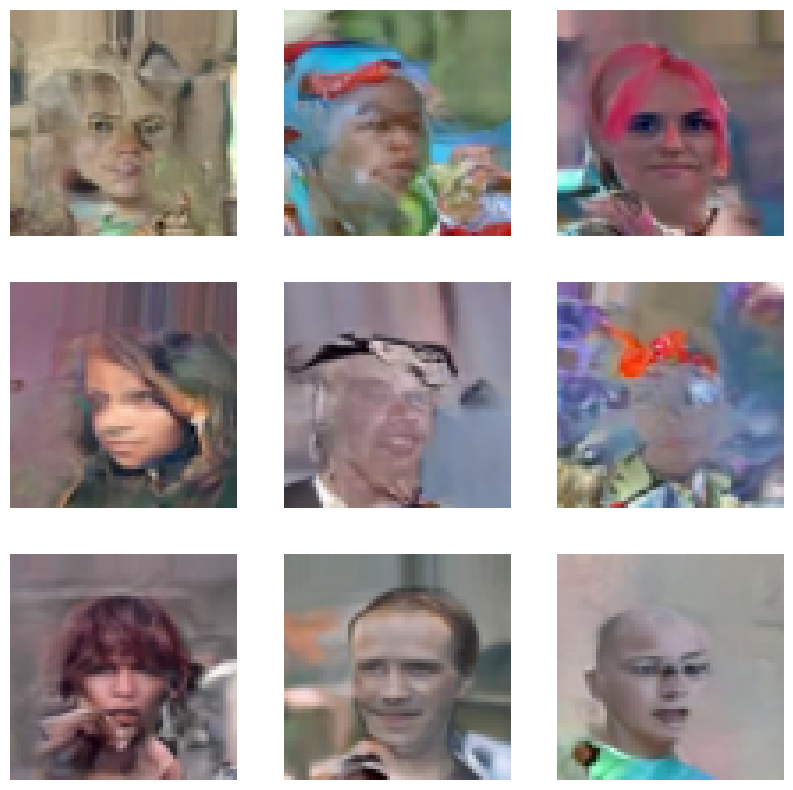

In [21]:
import numpy as np
num_images = 9

plt.figure(figsize=(10, 10)) 

for i in range(num_images):
    img = samples[-1][i] 
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    img = (img - img.min()) / (img.max() - img.min()) 

    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
    plt.imshow(img)
    plt.axis('off')  # Hide axis

    # Save the individual image with a unique name
    #plt.imsave(f"saved_image{i+1}.png", img)

#plt.tight_layout()
plt.show()

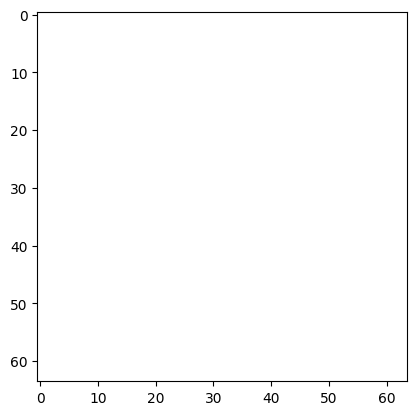

In [16]:
import matplotlib.animation as animation

random_index = 3

fig = plt.figure()
ims = []
#print(samples[2][0].shape)
for i in range(timesteps):
    img = samples[i][random_index]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    #img = samples[i][random_index].reshape(image_size, image_size, channels)
    img = (img - img.min()) / (img.max() - img.min())
    im = plt.imshow(img, animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#animate.save('diffusion_relu.gif')
plt.show()